## Yo!
So I've done some simple work with this dataset and acheved average MAE for sale prices around 12000 and for rent prices around 65.  
  
Here I want to show you what you can find with EDA, which variables might be worth to engineer and how GepPy library can help you with finding coordinates and addresses in order to obtain more information and improve your model. 

### Some preparation
Importing libraries:

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, LinearRegression, ElasticNet,  HuberRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error
from xgboost import XGBRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.utils import resample
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import KFold


import re

from geopandas.tools import geocode
import warnings
warnings.filterwarnings("ignore")

seed = 42

Introducting functions for EDA:

In [2]:
def missing(df):
    df_missing = pd.DataFrame(df.isna().sum().sort_values(ascending = False), columns = ['missing_count'])
    df_missing['missing_share'] = df_missing.missing_count / len(df)
    return df_missing

In [3]:
def simple_chart(df, x, title = None, hue = None):
    plt.figure(figsize = (10, 6))
    plt.title(title, fontsize=14)
    ax = sns.countplot(x = x, hue = hue, data = df)

In [4]:
def factor_chart(df, x, y, hue = None):
    ax = sns.factorplot(x = x, y = y, data = df, hue = hue, kind = 'box', size=6, aspect = 2)

In [5]:
def scatter(df, x, y, hue = None):
    plt.figure(figsize = (20, 10))
    ax = sns.scatterplot(x = x, y = y, data = df, hue = hue)
    plt.show()

A bit of styling

In [6]:
sns.set(style="darkgrid")

And there we go!

### Raw data exploration 

In [7]:
df = pd.read_csv("../input/riga-real-estate-dataset/riga_re.csv")

In [8]:
df.head()

,op_type,district,street,rooms,area,floor,total_floors,house_seria,house_type,condition,price,lat,lon
0,For rent,Purvciems,Dzelzavas 93,1,27.0,3.0,5.0,LT proj.,Brick-Panel,All amenities,250.0,56.955484,24.202139
1,For rent,Ziepniekkalns,Ozolciema 32,2,50.0,7.0,9.0,602.,Panel,All amenities,300.0,56.899798,24.098350
2,For sale,centrs,Ieroču 6,2,33.0,1.0,2.0,P. kara,Wood,Partial amenities,13500.0,56.975092,24.139884
3,For sale,Ķengarags,Maskavas 305,2,50.0,5.0,5.0,LT proj.,Panel,All amenities,34000.0,56.859788,24.308342
4,For rent,Teika,Zemgala gatve 80,3,76.0,3.0,12.0,Jaun.,Masonry,All amenities,490.0,56.977745,24.166042


In [9]:
missing(df)

,missing_count,missing_share
price,470,0.100235
street,452,0.096396
house_type,450,0.095969
house_seria,442,0.094263
condition,406,0.086586
area,364,0.077628
total_floors,344,0.073363
floor,333,0.071017
lon,207,0.044146
lat,207,0.044146


In [10]:
df[df.price.isna()]

,op_type,district,street,rooms,area,floor,total_floors,house_seria,house_type,condition,price,lat,lon
42,Buying,Pļavnieki,NaN,Citi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.314475,11.048029
48,Buying,Ķengarags,NaN,2,NaN,12.0,7.0,NaN,NaN,All amenities,NaN,46.314475,11.048029
49,Buying,Vecmīlgrāvis,NaN,NaN,9.0,99.0,9.0,NaN,NaN,NaN,NaN,46.314475,11.048029
51,Buying,Pļavnieki,NaN,Citi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.314475,11.048029
80,Renting,Āgenskalns,NaN,4,NaN,NaN,NaN,NaN,NaN,All amenities,NaN,46.314475,11.048029
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4640,Buying,Ķengarags,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.314475,11.048029
4650,Renting,Ziepniekkalns,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.314475,11.048029
4664,Renting,Ķengarags,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.314475,11.048029
4665,Renting,Imanta,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.314475,11.048029


We see that we have **10%** of dataset with missing price, that is our target variable.  
  
Moreover, if we take a closer look at the observations with missing price, we will se that they miss most information about other variables as well and contribute to the number of missings in other columns.  
  
As we do not have a test dataset, they have no use so I **remove them**

In [11]:
df_all = df[~df.price.isna()].reset_index(drop = True).copy()

In [12]:
missing(df_all) 

,missing_count,missing_share
lon,206,0.048827
lat,206,0.048827
total_floors,6,0.001422
street,5,0.001185
house_type,4,0.000948
house_seria,3,0.000711
floor,3,0.000711
area,3,0.000711
district,3,0.000711
condition,1,0.000237


**Wow**, this action has actually helped us to get rid of most other missing variables as well!  
  
Now, none of the variables have share of missing higher than 5% so all of them are worth to explore.

In [13]:
df_all.dtypes

op_type          object
district         object
street           object
rooms            object
area            float64
floor           float64
total_floors    float64
house_seria      object
house_type       object
condition        object
price           float64
lat             float64
lon             float64
dtype: object

Unexpectedly, rooms feature is categorical, we will take a closer look at it later on.

In [14]:
df_all.describe()

,area,floor,total_floors,price,lat,lon
count,4216.000000,4216.000000,4213.000000,4219.000000,4013.000000,4013.000000
mean,61.990088,3.595114,6.034180,58728.706803,56.888532,23.550595
std,35.795856,2.515898,3.548507,76252.501519,0.773243,8.144936
min,5.000000,1.000000,1.000000,5.000000,46.314475,-100.708194
25%,40.000000,2.000000,5.000000,450.000000,56.943222,24.095453
50%,53.050000,3.000000,5.000000,40000.000000,56.954831,24.127139
75%,76.000000,5.000000,7.000000,82000.000000,56.965045,24.173175
max,427.000000,24.000000,30.000000,830000.000000,59.347471,24.340866


Variance of some numeric variables is very high.  
  
Floor and max floor feature values are reasonable, but area, price, lat and lon features have some wierd values and definite mistakes so cleaning will be necessary.

In [15]:
print('Number of observations:', len(df_all), '\n')
print('Unique values:')
print(df_all.nunique().sort_values(ascending = False))

Number of observations: 4219 

Unique values:
street          2527
lon             2089
lat             2087
price           1055
area             331
district          48
total_floors      25
floor             22
house_seria       15
rooms              7
house_type         6
op_type            5
condition          3
dtype: int64


We can see that actually not all street addresses are unique, so there are some groups of apartments that are in the same building, so it can help us while imputing floors and areas.

### Data cleaning and missing imputation

I want to use street addresses to impute missing lat, lon and addresses.  
  
So let's fix missing streets first with their coordinates.

In [16]:
df_all[df_all.street.isna()]

,op_type,district,street,rooms,area,floor,total_floors,house_seria,house_type,condition,price,lat,lon
622,Renting,Imanta,NaN,2,NaN,NaN,NaN,Jaun.,NaN,All amenities,500.0,46.314475,11.048029
791,Renting,centrs,NaN,3,70.0,2.0,NaN,NaN,NaN,NaN,900.0,46.314475,11.048029
1068,Renting,Purvciems,NaN,3,65.0,NaN,NaN,NaN,NaN,All amenities,350.0,46.314475,11.048029
2089,Renting,centrs,NaN,1,NaN,2.0,NaN,NaN,NaN,All amenities,400.0,46.314475,11.048029
2673,Change,NaN,NaN,5,190.0,NaN,NaN,Priv. m.,Brick,All amenities,29900.0,46.314475,11.048029


Unfortunately we see, that lat and lon values for these 5 observation are just incorrect, because if you put them on the map, you'll find yourself at Italian mountains (I wish it could happen for real).  
  
Therefore, finding addresses for them is impossible. Considering the fact that these observations have a lot of other missing features as well, we'd better drop them.

In [17]:
df_all = df_all.drop(df_all[df_all.street.isna()].index).reset_index(drop = True)

In [18]:
missing(df_all) 

,missing_count,missing_share
lon,206,0.048885
lat,206,0.048885
district,2,0.000475
total_floors,1,0.000237
area,1,0.000237
rooms,1,0.000237
price,0,0.000000
condition,0,0.000000
house_type,0,0.000000
house_seria,0,0.000000


**Twofer**! Now, thanks to this drop, we should care about imputation for much less features.

Now I want to extract actual street names from 'street' feature in order to use it as a categorical variable and to impute missing districts.  

In [19]:
# Function for removing digits from a string

def no_digits(text):
    return ''.join([i for i in text if not i.isdigit()])

In [20]:
df_all['street_name_0'] = df_all['street'].apply(lambda x: no_digits(re.sub('\W+',' ', str(x))).strip())

In [21]:
df_all.head(3)

,op_type,district,street,rooms,area,floor,total_floors,house_seria,house_type,condition,price,lat,lon,street_name_0
0,For rent,Purvciems,Dzelzavas 93,1,27.0,3.0,5.0,LT proj.,Brick-Panel,All amenities,250.0,56.955484,24.202139,Dzelzavas
1,For rent,Ziepniekkalns,Ozolciema 32,2,50.0,7.0,9.0,602.,Panel,All amenities,300.0,56.899798,24.098350,Ozolciema
2,For sale,centrs,Ieroču 6,2,33.0,1.0,2.0,P. kara,Wood,Partial amenities,13500.0,56.975092,24.139884,Ieroču


In [22]:
# set(df_all.street_name_0.values)

If you uncomment and launch the line above, you'll see that some useless liters have left, so we will fix em as well.

In [23]:
df_all['st_n'] = None
for i in range(len(df_all)):
    if ((df_all.loc[i, 'street_name_0'][:3] != 'St ') & (df_all.loc[i, 'street_name_0'][:2] != 'J ') & 
        (df_all.loc[i, 'street_name_0'][:2] != 'M ')):
        df_all.loc[i, 'st_n'] = df_all.loc[i, 'street_name_0'].split(' ')[0]
    elif (df_all.loc[i, 'street_name_0'][:3] != 'St '):
         df_all.loc[i, 'st_n'] = df_all.loc[i, 'street_name_0'].split(' ')[0] + ' ' + df_all.loc[i, 'street_name_0'].split(' ')[1]
    else:
        df_all.loc[i, 'st_n'] = 'St ' + df_all.loc[i, 'street_name_0'].split(' ')[1]

In [24]:
#set(df_all.st_n.values)

Now it's better!

In [25]:
df_all.drop(['street_name_0'], axis = 1, inplace = True)

Now let's impute **districts**.

In [26]:
df_all[df_all.district.isna()]

,op_type,district,street,rooms,area,floor,total_floors,house_seria,house_type,condition,price,lat,lon,st_n
1107,For sale,NaN,Ogļu 32,3,79.0,1.0,4.0,Renov.,Masonry,All amenities,260000.0,56.960841,24.081765,Ogļu
3172,For sale,NaN,Pupuku iela 9,2,55.0,1.0,5.0,Jaun.,Panel,All amenities,90000.0,56.905114,24.143239,Pupuku


In [27]:
df_all[df_all.st_n == 'Ogļu'].groupby('district').count()

,op_type,street,rooms,area,floor,total_floors,house_seria,house_type,condition,price,lat,lon,st_n
district,,,,,,,,,,,,,
Ķīpsala,10,10,10,10,10,10,10,10,10,10,10,10,10


See that Ogļu street belongs to Ķīpsala district strictly, so we impute it first.

In [28]:
df_all.loc[1107, 'district'] = 'Ogļu'

In [29]:
df_all[df_all.st_n == 'Pupuku iela'].groupby('district').count()

,op_type,street,rooms,area,floor,total_floors,house_seria,house_type,condition,price,lat,lon,st_n
district,,,,,,,,,,,,,


Oh, but looks like Pupuku iela is unique, so we use google maps then and find that this street belongs to Bišumuiža district.

In [30]:
df_all.loc[3172, 'district'] = 'Bišumuiža'

Now let's impute lat and lan.  
  
For this purpose I will use **GeoPy** library.

In [31]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="specify_your_app_name_here")

In [32]:
def lat(add):
    try:
        return geolocator.geocode(add).latitude
    except:
        return None

def lon(add):
    try:
        return geolocator.geocode(add).longitude
    except:
        return None

But as we've already noticed, some lat and lan values are **wrong**, so we have to make them empty and impute them by using their street addresses and GeoPy

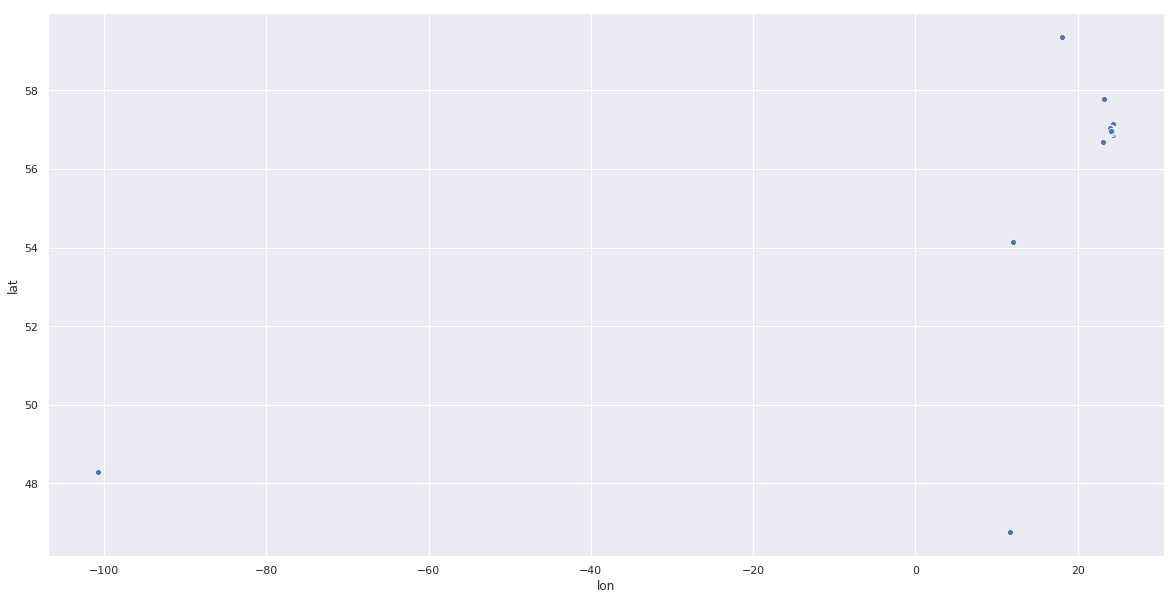

In [33]:
scatter(df_all, x = 'lon', y = 'lat')

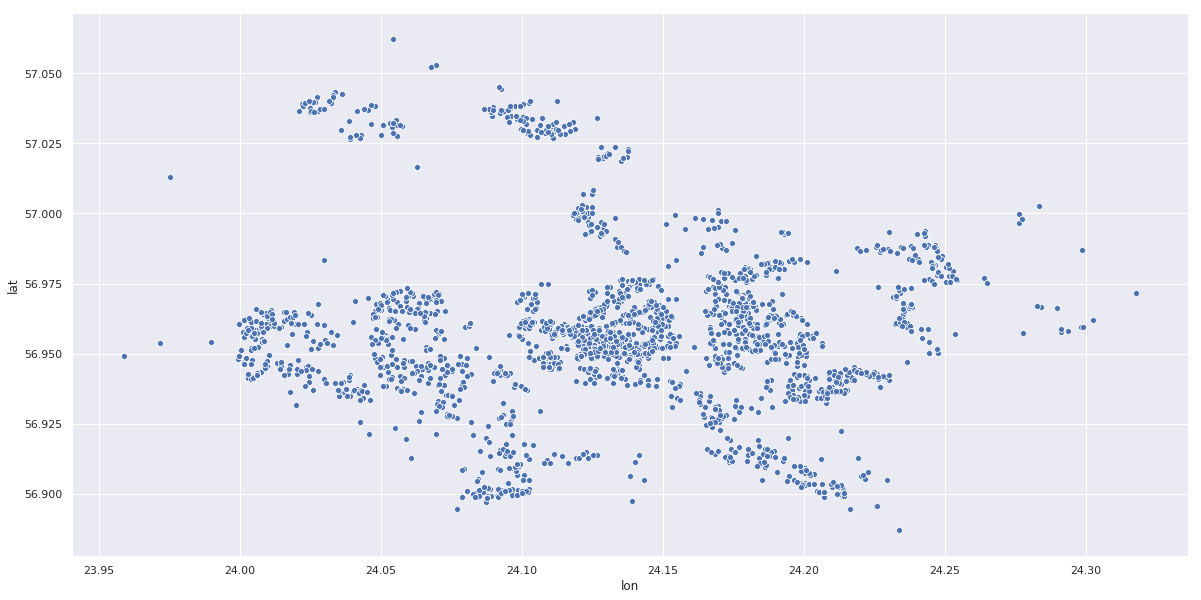

In [34]:
scatter(df_all[(df_all.lat>56.88)&(df_all.lat<57.1)&(df_all.lon>20)], x = 'lon', y = 'lat')

Now it's better

In [35]:
df_all.loc[~((df_all.lat>56.88)&(df_all.lat<57.1)&(df_all.lon>20)), ['lat', 'lon']] = None

And now we come to the most painful part of this project for me.  
 
The problem with finding coordinates with geopy and all other libraries is that the address should be specifically correct in order to return desired coordinates. 

For example, if you request 'Jūrmalas g. 15' coordinates, you wont get any result, because geopy cannot understand 'g.', so we have to replace all the instances of 'Jūrmalas g.' on 'Jūrmalas gatve'.  
 
Or if you request 'Skolas 38' it will send you to a Norway hinterland.  

To fix all of this has brought me a lot of pain, but I did it so below is what I could do to achieve the result.  
  
Also important to note, that geopy api sometimes throws you **connection errors**.  
I made my coordinate finding functions robust to it, but it still requires to execute the line with the function **several times**

In [36]:
df_all['district'] = df_all["district"].replace('Krasta r-ns', 'Krasta masīvs')

In [37]:
df_all['Street_New'] = df_all['street']

In [38]:
df_all['Street_New'] = df_all["Street_New"].apply(lambda x: str(x).replace(' g.', ' gatve'))
df_all['Street_New'] = df_all["Street_New"].apply(lambda x: str(x).replace(' k-1', '').strip())
df_all['Street_New'] = df_all["Street_New"].apply(lambda x: str(x).replace(' k-2', '').strip())
df_all['Street_New'] = df_all["Street_New"].apply(lambda x: str(x).replace(' k1', '').strip())
df_all['Street_New'] = df_all["Street_New"].apply(lambda x: str(x).replace(' k 1', '').strip())
df_all['Street_New'] = df_all["Street_New"].apply(lambda x: str(x).replace(' k-1', '').strip())
df_all['Street_New'] = df_all["Street_New"].apply(lambda x: str(x).replace(' k-3', '').strip())
df_all['Street_New'] = df_all["Street_New"].apply(lambda x: str(x).replace('-k-3', '').strip())
df_all['Street_New'] = df_all["Street_New"].apply(lambda x: str(x).replace(' k-4', '').strip())
df_all['Street_New'] = df_all["Street_New"].apply(lambda x: str(x).replace(' k. 1', '').strip())
df_all['Street_New'] = df_all["Street_New"].apply(lambda x: str(x).replace('k5', '').strip())
df_all['Street_New'] = df_all["Street_New"].apply(lambda x: str(x).replace('krastm.', 'krastmala'))
df_all['Street_New'] = df_all["Street_New"].apply(lambda x: str(x).replace(' pr.', ' prospekts'))
df_all['Street_New'] = df_all["Street_New"].apply(lambda x: str(x).replace('Pulkv.', 'Pulkveža'))
df_all['Street_New'] = df_all["Street_New"].apply(lambda x: str(x).replace('bulv.', 'bulvāris'))
df_all['Street_New'] = df_all["Street_New"].apply(lambda x: str(x).replace('šķ. l.', 'šķērslīnija'))
df_all['Street_New'] = df_all["Street_New"].apply(lambda x: str(x).replace('šķ l.', 'šķērslīnija'))
df_all['Street_New'] = df_all["Street_New"].apply(lambda x: str(x).replace(' l. ', ' līnija '))
df_all['Street_New'] = df_all["Street_New"].apply(lambda x: str(x).replace(' d. ', ' dambis '))
df_all['Street_New'] = df_all["Street_New"].apply(lambda x: str(x).replace('J. Daliņa', 'Jāņa Daliņa'))
df_all['Street_New'] = df_all["Street_New"].apply(lambda x: str(x).replace('J. Vācieša', 'Jukuma Vācieša'))
df_all['Street_New'] = df_all["Street_New"].apply(lambda x: str(x).replace(' g. ', ' gatve '))
df_all['Street_New'] = df_all["Street_New"].apply(lambda x: str(x).replace(' lauk.', ' laukums'))
df_all['Street_New'] = df_all["Street_New"].apply(lambda x: str(x).replace('k1', '').strip())
df_all['Street_New'] = df_all["Street_New"].apply(lambda x: str(x).replace('k2', '').strip())
df_all['Street_New'] = df_all["Street_New"].apply(lambda x: str(x).replace('-13d', '-13'))
df_all['Street_New'] = df_all["Street_New"].apply(lambda x: str(x).replace('-36d', '-36'))
df_all['Street_New'] = df_all["Street_New"].apply(lambda x: str(x).replace('-45d', '-45'))
df_all['Street_New'] = df_all["Street_New"].apply(lambda x: str(x).replace('-94b', '-94'))
df_all['Street_New'] = df_all["Street_New"].apply(lambda x: str(x).replace(' 19/1', ' 19'))
df_all['Street_New'] = df_all["Street_New"].apply(lambda x: str(x).replace('M. Balasta', 'Mazais Balasta'))
df_all['Street_New'] = df_all["Street_New"].apply(lambda x: str(x).replace('M. Kuldīgas', 'Mazā Kuldīgas'))
df_all['Street_New'] = df_all["Street_New"].apply(lambda x: str(x).replace('M. Nometņu', 'Mazā Nometņu'))
df_all['Street_New'] = df_all["Street_New"].apply(lambda x: str(x).replace('Asteres', 'Aisteres'))
df_all['Street_New'] = df_all["Street_New"].apply(lambda x: str(x).replace(' 17 a', ' 17'))
df_all['Street_New'] = df_all["Street_New"].apply(lambda x: str(x).replace(' š. ', ' šoseja '))

In [39]:
df_all['Street_Full'] = df_all.apply(lambda x: str(x['Street_New']).split(' ')[0] + ' iela ' + str(x['Street_New']).split(' ')[1] +
                                    ', ' + str(x['district']) + ', ' + 'Rīga' if 
                                    len(x['Street_New'].split(' ')) == 2 else str(x['Street_New']) + ', ' + 
                                    'Rīga', axis = 1)

**ATTENTION!**   
  
The following code is using GeoPy coordinates fuctions, but they **do not work well** if you execute them on kaggle environment!  
 
Therefore, if you want to perform the same coordinate imputation on your data, please, copy the following commented code lines and execute them on your environment (Jupiter, for ex.)
 
Here instead I will use the preloaded dataset that is the result of the commented code lines below.

In [40]:
# This lines request full address that is stored in Street_Full feature. 
# Has to be launched 3-4 times, until the number of missing values stops decreasing (reaching 24 for both lat and lon specifically in this case)

#df_all['lat'] = df_all.apply(lambda x: lat(str(x['Street_Full'])) if np.isnan(x['lat']) == True else x['lat'], axis=1)
#df_all['lon'] = df_all.apply(lambda x: lon(str(x['Street_Full'])) if np.isnan(x['lon']) == True else x['lon'], axis=1)

In [41]:
# However, some full addresses do not work with district name, so for the left missings we use only street name and 'Riga'
# Also 2-3 times to execute (until 1 missing left for both lat and lon). 

#df_all['lat'] = df_all.apply(lambda x: lat(str(x['Street_Full'].split(',')[0]) + str(x['Street_Full'].split(',')[-1])) if np.isnan(x['lat']) == True else x['lat'], axis=1)
#df_all['lon'] = df_all.apply(lambda x: lon(str(x['Street_Full'].split(',')[0]) + str(x['Street_Full'].split(',')[-1])) if np.isnan(x['lon']) == True else x['lon'], axis=1)

In [42]:
# Remaining missing did not work with full address, but only street name was enough here.
# 1 execution is enough here

#df_all['lat'] = df_all.apply(lambda x: lat(str(x['Street_Full'].split(',')[0])) if np.isnan(x['lat']) == True else x['lat'], axis=1)
#df_all['lon'] = df_all.apply(lambda x: lon(str(x['Street_Full'].split(',')[0])) if np.isnan(x['lon']) == True else x['lon'], axis=1)

Here is a preloaded dataset that I use for the following analysis here.  
  
However, **DO NOT FORGET** to remove 2 following lines if you want to use geopy on your env.

In [43]:
riga_fixed_coordinates = pd.read_csv('../input/riga-fixed-coordinates/riga_fixed_coordinates.csv')
missing(riga_fixed_coordinates)

,missing_count,missing_share
total_floors,1,0.000237
area,1,0.000237
rooms,1,0.000237
Street_Full,0,0.000000
Street_New,0,0.000000
st_n,0,0.000000
lon,0,0.000000
lat,0,0.000000
price,0,0.000000
condition,0,0.000000


In [44]:
df_all = riga_fixed_coordinates.copy()

In [45]:
df_all[~(df_all.lat>56.88)&(df_all.lat<57.1)&(df_all.lon>20)]

,op_type,district,street,rooms,area,floor,total_floors,house_seria,house_type,condition,price,lat,lon,st_n,Street_New,Street_Full


Phew, that was tiresome!  
  
But as we see, we successfully imputed all the coordinates and none of them are out of Riga boundaries now.  

Let's check it on 'map' again.

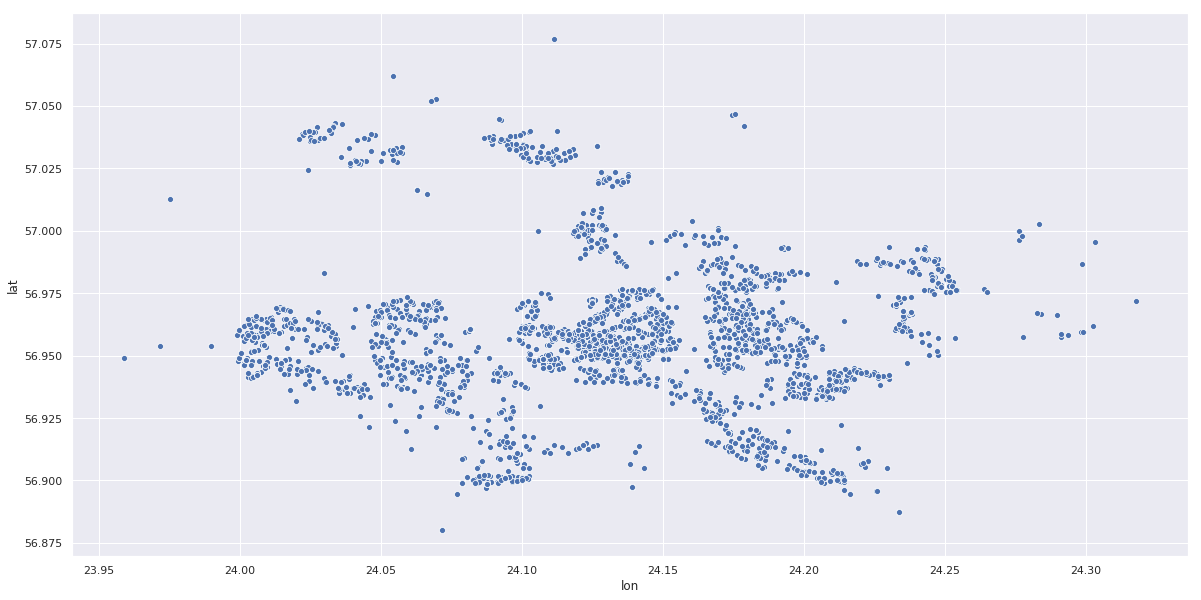

In [46]:
scatter(df_all, x = 'lon', y = 'lat')

**Splendid!**  

Now it's time to imput remaining missings.  
 
Go with **area**.

In [47]:
df_all[df_all.area.isna()]

,op_type,district,street,rooms,area,floor,total_floors,house_seria,house_type,condition,price,lat,lon,st_n,Street_New,Street_Full
3981,Change,Imanta,Slokas 130,3,NaN,1.0,12.0,Čehu pr.,Brick,All amenities,110000.0,56.96381,24.019514,Slokas,Slokas 130,"Slokas iela 130, Imanta, Rīga"


Let's look if there is a flat with the same addresses.  
  
I assume that flats in the same buildings will have more or less the same Area/Rooms, so we can use this as a proxy.

In [48]:
df_all[df_all.street == 'Slokas 130']

,op_type,district,street,rooms,area,floor,total_floors,house_seria,house_type,condition,price,lat,lon,st_n,Street_New,Street_Full
1606,For sale,Imanta,Slokas 130,4,110.0,1.0,12.0,Čehu pr.,Brick,All amenities,110000.0,56.96381,24.019514,Slokas,Slokas 130,"Slokas iela 130, Imanta, Rīga"
3981,Change,Imanta,Slokas 130,3,NaN,1.0,12.0,Čehu pr.,Brick,All amenities,110000.0,56.96381,24.019514,Slokas,Slokas 130,"Slokas iela 130, Imanta, Rīga"


In [49]:
# Therefore
df_all.loc[3981, 'area'] = 80.0

Now go with imputing rooms and use the same approach.

In [50]:
df_all[df_all.rooms.isna()]

,op_type,district,street,rooms,area,floor,total_floors,house_seria,house_type,condition,price,lat,lon,st_n,Street_New,Street_Full
1617,For sale,centrs,Dārzaugļu 1,NaN,214.0,5.0,5.0,Renov.,Brick-Panel,All amenities,165000.0,56.965284,24.151135,Dārzaugļu,Dārzaugļu 1,"Dārzaugļu iela 1, centrs, Rīga"


In [51]:
df_all[df_all.street == 'Dārzaugļu 1']

,op_type,district,street,rooms,area,floor,total_floors,house_seria,house_type,condition,price,lat,lon,st_n,Street_New,Street_Full
1617,For sale,centrs,Dārzaugļu 1,NaN,214.0,5.0,5.0,Renov.,Brick-Panel,All amenities,165000.0,56.965284,24.151135,Dārzaugļu,Dārzaugļu 1,"Dārzaugļu iela 1, centrs, Rīga"
3565,For sale,Grīziņkalns,Dārzaugļu 1,4,108.0,2.0,6.0,Renov.,Panel-Brick,All amenities,140400.0,56.965284,24.151135,Dārzaugļu,Dārzaugļu 1,"Dārzaugļu iela 1, Grīziņkalns, Rīga"


Double area, but I doubt to put 8 rooms here.  
  
Let's look at rooms number distribution by rooms:

In [52]:
df_all.groupby(['rooms']).area.median()

rooms
1        30.0
2        50.0
3        74.0
4       104.0
5       140.0
6       173.5
Citi    189.5
Name: area, dtype: float64

Now we can see why rooms feature is categorical.  
  
For some reason there is a **'Citi'** value in rooms that means 'other'.  
 
Let's try to figure out what it can give us.

In [53]:
df_all[df_all.rooms == 'Citi']

,op_type,district,street,rooms,area,floor,total_floors,house_seria,house_type,condition,price,lat,lon,st_n,Street_New,Street_Full
75,For rent,Sarkandaugava,Tilta 5,Citi,76.0,2.0,4.0,P. kara,Masonry,All amenities,295.0,56.995073,24.127396,Tilta,Tilta 5,"Tilta iela 5, Sarkandaugava, Rīga"
296,For rent,centrs,Brīvības 103,Citi,300.0,4.0,5.0,Specpr.,Masonry,All amenities,350.0,56.961433,24.133111,Brīvības,Brīvības 103,"Brīvības iela 103, centrs, Rīga"
357,For sale,centrs,Blaumaņa 9,Citi,287.0,5.0,6.0,Renov.,Brick,All amenities,298544.0,56.953926,24.123761,Blaumaņa,Blaumaņa 9,"Blaumaņa iela 9, centrs, Rīga"
499,For sale,Vecrīga,Kungu 25,Citi,330.0,5.0,6.0,Specpr.,Panel,All amenities,474990.0,56.945338,24.109464,Kungu,Kungu 25,"Kungu iela 25, Vecrīga, Rīga"
556,For sale,centrs,Blaumaņa 36,Citi,190.0,4.0,5.0,P. kara,Brick,All amenities,350000.0,56.951729,24.125815,Blaumaņa,Blaumaņa 36,"Blaumaņa iela 36, centrs, Rīga"
809,For sale,Āgenskalns,M. Nometņu 85,Citi,207.0,2.0,2.0,P. kara,Wood,All amenities,79000.0,56.937791,24.055589,M Nometņu,Mazā Nometņu 85,"Mazā Nometņu 85, Rīga"
1445,For sale,centrs,Hospitāļu 40,Citi,189.0,3.0,4.0,Staļina,Masonry,All amenities,240000.0,56.975886,24.139173,Hospitāļu,Hospitāļu 40,"Hospitāļu iela 40, centrs, Rīga"
1844,For sale,centrs,Laboratorijas 1,Citi,115.4,2.0,2.0,P. kara,Wood,Partial amenities,50000.0,56.958793,24.149118,Laboratorijas,Laboratorijas 1,"Laboratorijas iela 1, centrs, Rīga"
1870,For sale,Vecmīlgrāvis,Emmas 12a,Citi,188.0,1.0,3.0,Staļina,Masonry,All amenities,49000.0,57.029079,24.111099,Emmas,Emmas 12a,"Emmas iela 12a, Vecmīlgrāvis, Rīga"
2023,For sale,centrs,Birznieka-Upīša 6,Citi,195.0,2.0,3.0,P. kara,Wood,All amenities,159000.0,56.948547,24.124454,Birznieka,Birznieka-Upīša 6,"Birznieka-Upīša iela 6, centrs, Rīga"


As we see, there are only 12 observations with this value of floor and they vary a lot, but most do have comparatively large area that makes them outliers.  
  
I would assume that these observations do have some unique certain specifics that can impact their price, but they are very few, so I just decided to drop them.

In [54]:
df_all = df_all.drop(df_all[df_all.rooms == 'Citi'].index, axis = 0).reset_index(drop = True)

In [55]:
# Look at the missing again as index was reseted
df_all[df_all.rooms.isna()]

,op_type,district,street,rooms,area,floor,total_floors,house_seria,house_type,condition,price,lat,lon,st_n,Street_New,Street_Full
1610,For sale,centrs,Dārzaugļu 1,NaN,214.0,5.0,5.0,Renov.,Brick-Panel,All amenities,165000.0,56.965284,24.151135,Dārzaugļu,Dārzaugļu 1,"Dārzaugļu iela 1, centrs, Rīga"


So from what's left, we can impute '6' for our missing room. 

In [56]:
df_all.loc[1610, 'rooms'] = '6'

And now introduce numeric feature of rooms:

In [57]:
df_all['rooms_num']= df_all['rooms'].astype('int64')

Imputing total floors now.  
  
And again, same addresses should help.

In [58]:
df_all[df_all.total_floors.isna()]

,op_type,district,street,rooms,area,floor,total_floors,house_seria,house_type,condition,price,lat,lon,st_n,Street_New,Street_Full,rooms_num
1902,Other,Imanta,Zentenes 18,1,15.0,7.0,NaN,119.,Panel,All amenities,175.0,56.961863,24.003491,Zentenes,Zentenes 18,"Zentenes iela 18, Imanta, Rīga",1


In [59]:
df_all[df_all.street == 'Zentenes 18']

,op_type,district,street,rooms,area,floor,total_floors,house_seria,house_type,condition,price,lat,lon,st_n,Street_New,Street_Full,rooms_num
1186,For sale,Imanta,Zentenes 18,3,62.0,3.0,9.0,602.,Panel,All amenities,51000.0,56.961863,24.003491,Zentenes,Zentenes 18,"Zentenes iela 18, Imanta, Rīga",3
1378,For sale,Imanta,Zentenes 18,2,49.0,7.0,9.0,602.,Panel,All amenities,46000.0,56.961863,24.003491,Zentenes,Zentenes 18,"Zentenes iela 18, Imanta, Rīga",2
1843,For rent,Imanta,Zentenes 18,2,49.0,9.0,9.0,602.,Panel,All amenities,35.0,56.961863,24.003491,Zentenes,Zentenes 18,"Zentenes iela 18, Imanta, Rīga",2
1902,Other,Imanta,Zentenes 18,1,15.0,7.0,NaN,119.,Panel,All amenities,175.0,56.961863,24.003491,Zentenes,Zentenes 18,"Zentenes iela 18, Imanta, Rīga",1


Value for imputation is clearly visible.

In [60]:
df_all.loc[1902, 'total_floors'] = 9.0

And now we're done with imputation!  
  
No missings left!

In [61]:
missing(df_all)

,missing_count,missing_share
rooms_num,0,0.0
house_seria,0,0.0
district,0,0.0
street,0,0.0
rooms,0,0.0
area,0,0.0
floor,0,0.0
total_floors,0,0.0
house_type,0,0.0
Street_Full,0,0.0


### EDA

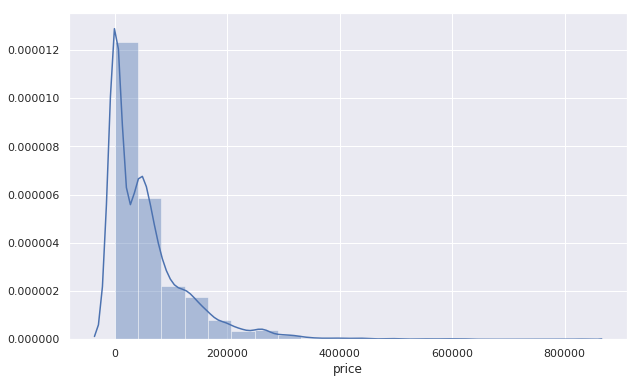

In [62]:
plt.figure(figsize = (10, 6))
ax = sns.distplot(df_all.price, bins = 20) 

Distribution range of price is wild. Why is it so?  
  
Let's try to find some clues in our features.

**Op_type**

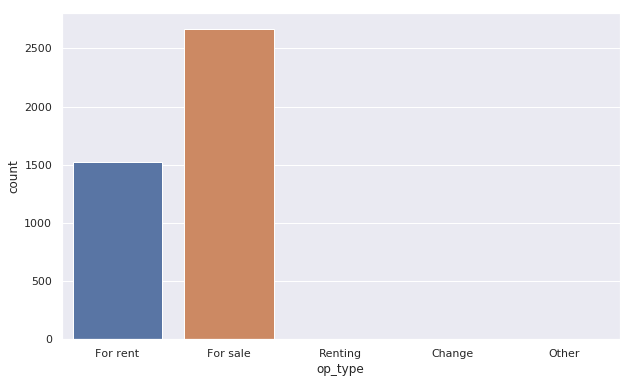

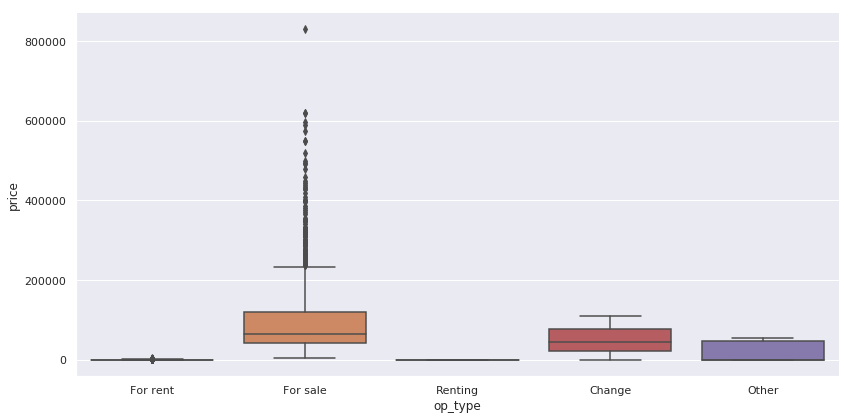

In [63]:
simple_chart(df_all, x = 'op_type')
factor_chart(df_all, x = 'op_type', y = 'price', hue = None)

And here we found it!  
  
Obviously, montly payment price for rent is much smaller than sale price of a whole apartment so these are clearly 2 different targets.  
  
Therefore, as we have quite enough observations for both major categories, it worths to separate the dataset on 2 parts for the further analysis and modelling later on.  
  
But before what about other op_type values?

In [64]:
df_all[~df_all.op_type.isin(['For rent', 'For sale'])]

,op_type,district,street,rooms,area,floor,total_floors,house_seria,house_type,condition,price,lat,lon,st_n,Street_New,Street_Full,rooms_num
178,Renting,centrs,Raiņa bulv. 1,2,50.0,1.0,5.0,P. kara,Brick-Panel,All amenities,500.0,56.954380,24.108966,Raiņa,Raiņa bulvāris 1,"Raiņa bulvāris 1, Rīga",2
1425,Change,Pļavnieki,Deglava,1,38.0,2.0,5.0,103.,Brick,All amenities,45000.0,56.952481,24.161031,Deglava,Deglava,"Deglava, Rīga",1
1902,Other,Imanta,Zentenes 18,1,15.0,7.0,9.0,119.,Panel,All amenities,175.0,56.961863,24.003491,Zentenes,Zentenes 18,"Zentenes iela 18, Imanta, Rīga",1
1948,Other,centrs,Kalniņa 1a,1,30.0,4.0,5.0,P. kara,Brick,All amenities,10.0,56.949448,24.120599,Kalniņa,Kalniņa 1a,"Kalniņa iela 1a, centrs, Rīga",1
2254,Other,Ķengarags,Ikšķiles 2,3,48.0,4.0,9.0,Renov.,Panel-Brick,All amenities,47990.0,56.900848,24.205359,Ikšķiles,Ikšķiles 2,"Ikšķiles iela 2, Ķengarags, Rīga",3
2360,Other,centrs,Gogoļa 23,1,18.0,2.0,2.0,Renov.,Wood,All amenities,140.0,56.942642,24.125564,Gogoļa,Gogoļa 23,"Gogoļa iela 23, centrs, Rīga",1
2541,Other,Ķengarags,Ikšķiles 2,3,49.0,2.0,9.0,Renov.,Panel-Brick,All amenities,53990.0,56.900848,24.205359,Ikšķiles,Ikšķiles 2,"Ikšķiles iela 2, Ķengarags, Rīga",3
2679,Change,Dzegužkalns,Tapešu,3,60.0,1.0,5.0,LT proj.,Panel,All amenities,60.0,56.941069,24.052744,Tapešu,Tapešu,"Tapešu, Rīga",3
3967,Change,Imanta,Slokas 130,3,80.0,1.0,12.0,Čehu pr.,Brick,All amenities,110000.0,56.963810,24.019514,Slokas,Slokas 130,"Slokas iela 130, Imanta, Rīga",3


We can directly notice by the price value, which of the observations with other op_type actually represent either for rent or for sale types.  
  
So we fix them and leave only 2 major op_types in order to split the dataset later.

In [65]:
df_all.loc[~df_all.op_type.isin(['For rent', 'For sale']) & (df_all.price < 1000), 'op_type'] = 'For rent'

In [66]:
df_all.loc[~df_all.op_type.isin(['For rent', 'For sale']) & (df_all.price > 1000), 'op_type'] = 'For sale'

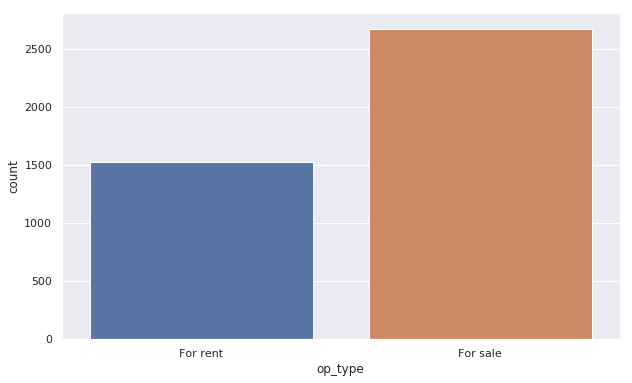

In [67]:
simple_chart(df_all, x = 'op_type')

**Area**  
  
  
Expectedly, one of the most important features.

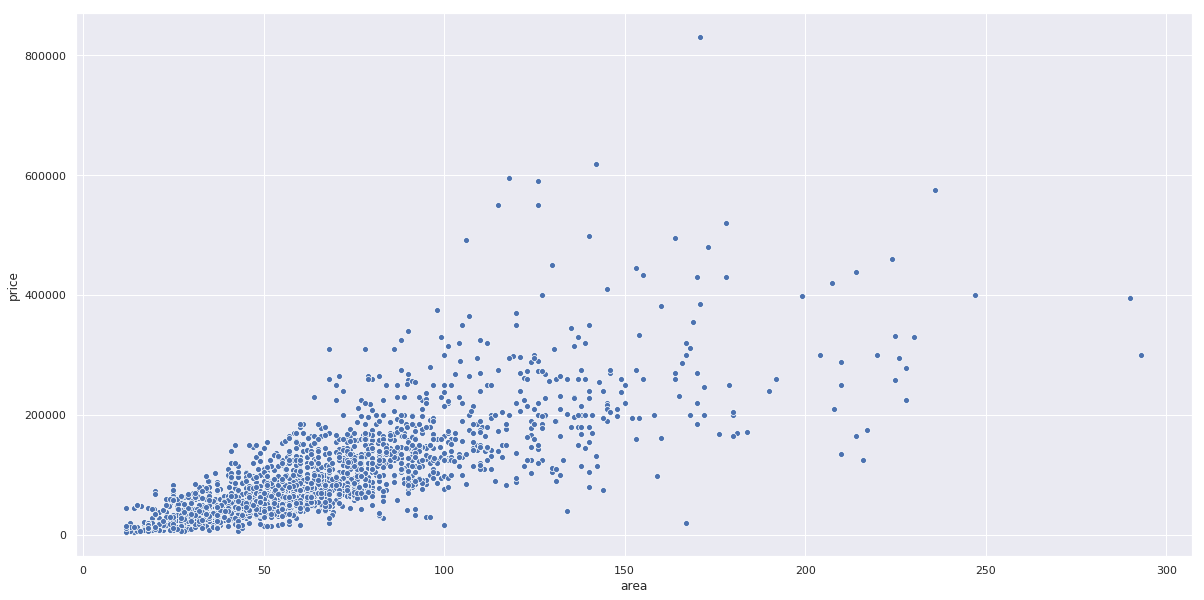

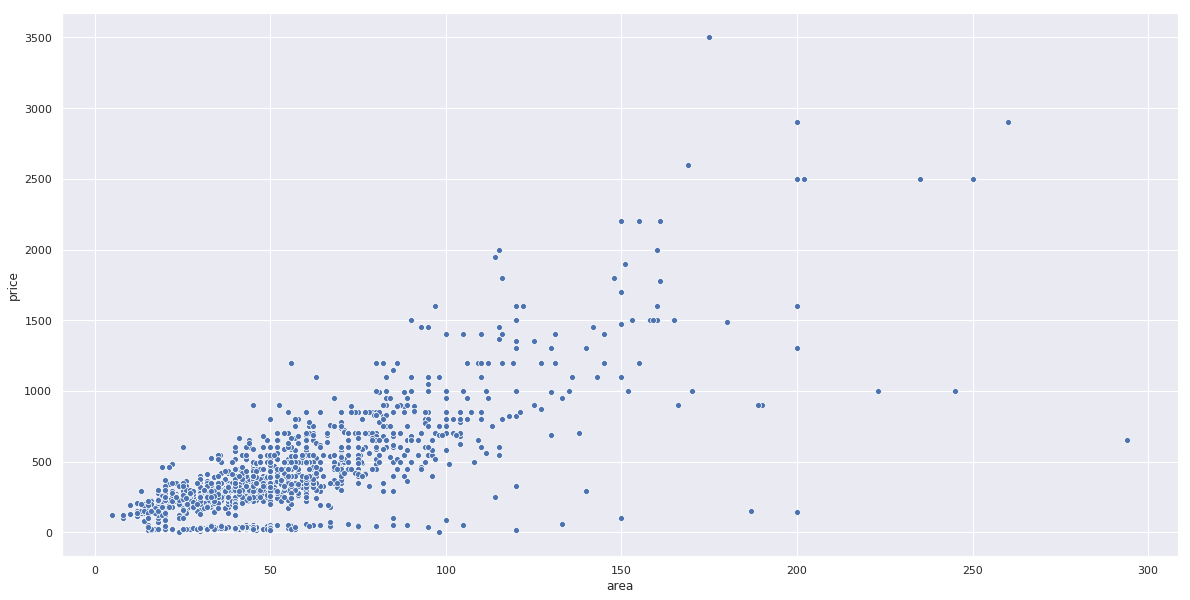

In [68]:
scatter(df_all[df_all.op_type == 'For sale'], x = 'area', y = 'price', hue = None)
scatter(df_all[df_all.op_type == 'For rent'], x = 'area', y = 'price', hue = None)

No surprise, strong positive correlation.  
  
However, we can notice, that dots are highly dispersed and there is definitely heteroskedasticity problem here.  
 
One of the ways to handle it is to use log1p of the target variable instead of the target itself. This makes a model robust to outliers and usually obtains better accuracy.
 
Nevertheless, in my case it did not help as much as outliers removal, so here I will use only it.

**Condition**

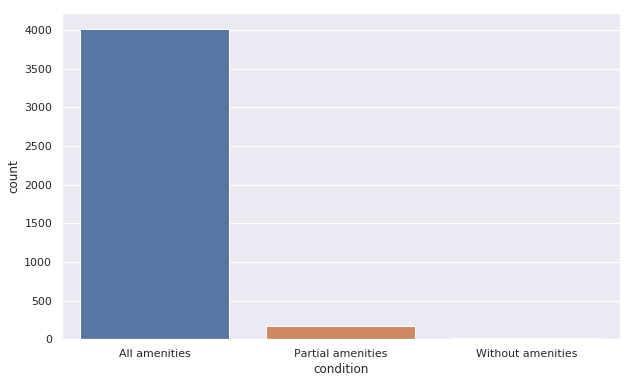

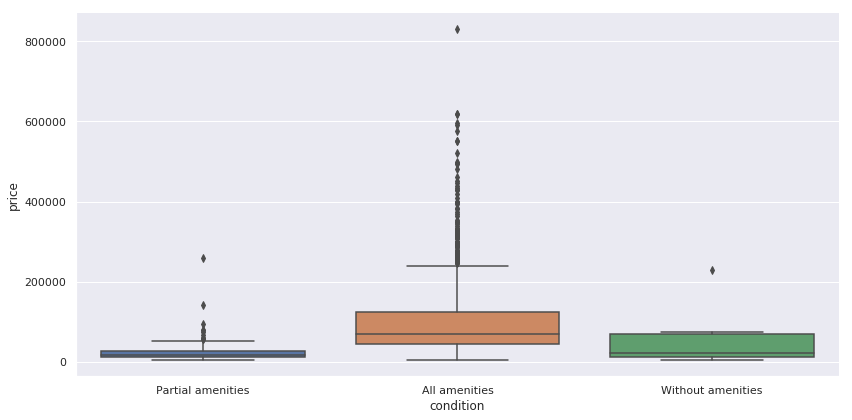

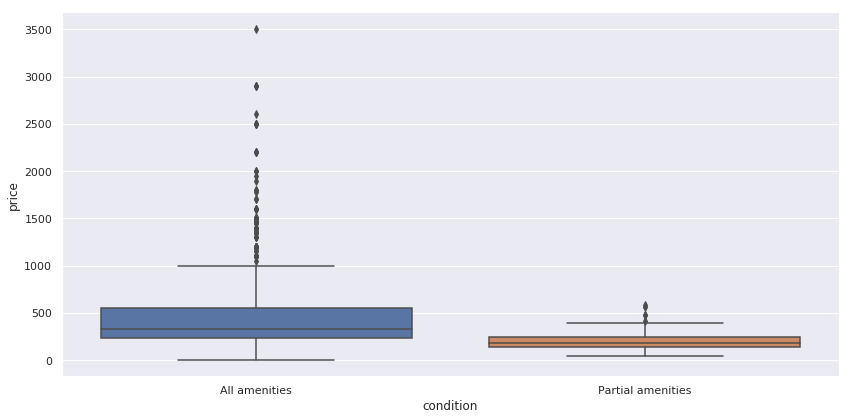

In [69]:
simple_chart(df_all, x = 'condition')
factor_chart(df_all[df_all.op_type == 'For sale'], x = 'condition', y = 'price', hue = None)
factor_chart(df_all[df_all.op_type == 'For rent'], x = 'condition', y = 'price', hue = None)

Apartments with all amenities do have higher price than with partial or without.  
  
At the same time, the number of observations without amenities is insignificantly slow, so I just introduce a dummy for All amenities to represent this condition difference in the model.

In [70]:
df_all['All_Amen'] = 0
df_all.loc[df_all.condition == 'All amenities', 'All_Amen'] = 1

**Rooms**

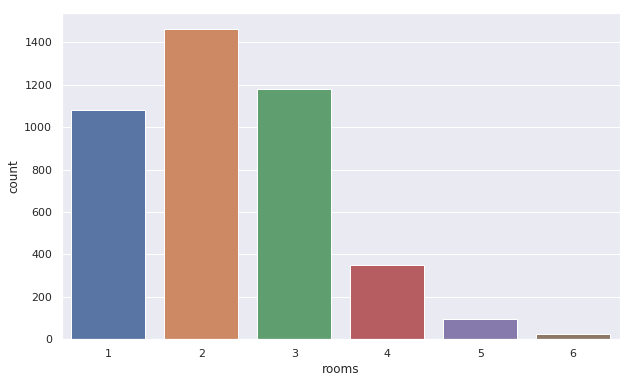

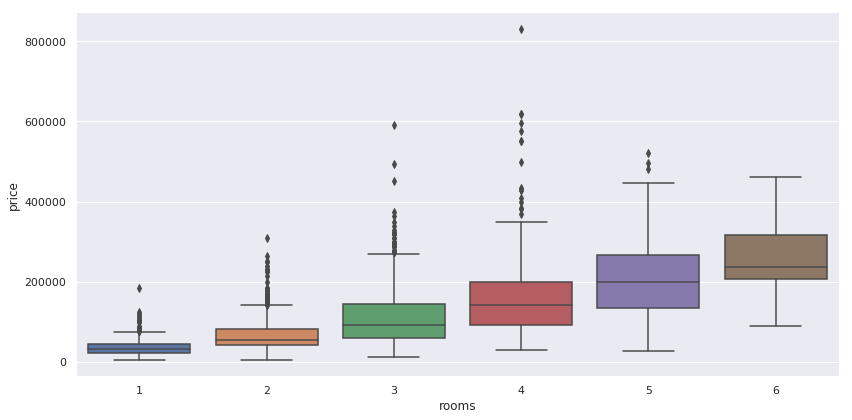

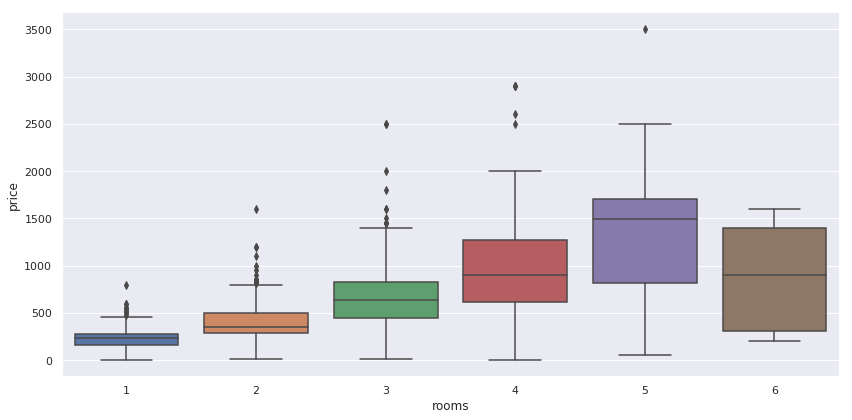

In [71]:
simple_chart(df_all, x = 'rooms') 
factor_chart(df_all[df_all.op_type == 'For sale'], x = 'rooms', y = 'price', hue = None)
factor_chart(df_all[df_all.op_type == 'For rent'], x = 'rooms', y = 'price', hue = None)

Alright, no surprise that higher numbers of rooms correlated with higher prices.  
  
Although, it's surprising, that 6 rooms flats for rent are cheaper than 5 rooms - other features impact might be involved.

**Floor**

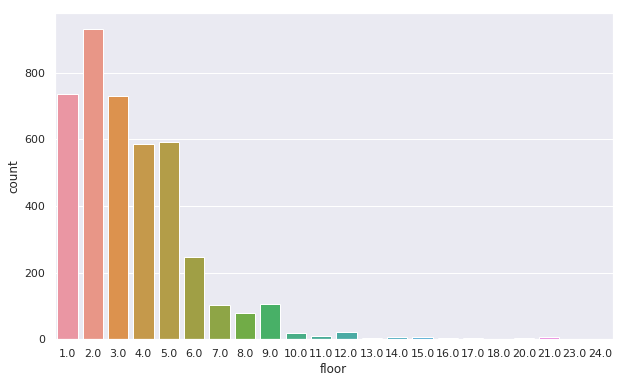

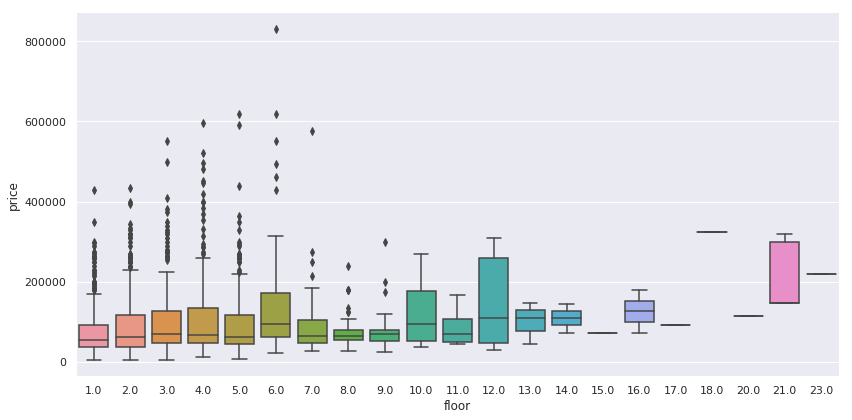

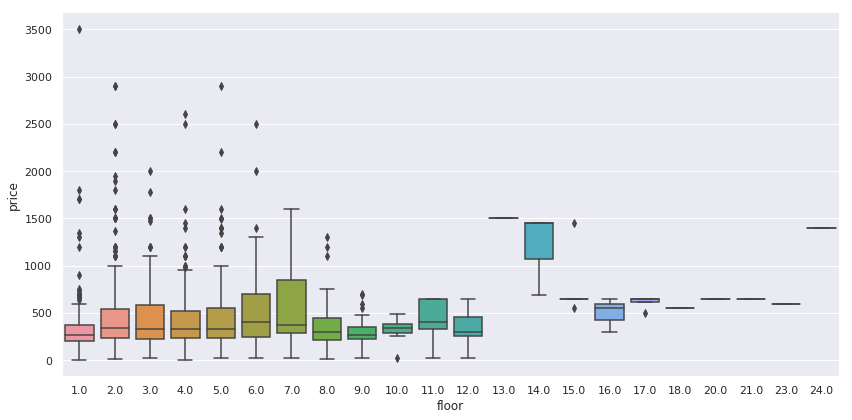

In [72]:
simple_chart(df_all, x = 'floor')
factor_chart(df_all[df_all.op_type == 'For sale'], x = 'floor', y = 'price', hue = None)
factor_chart(df_all[df_all.op_type == 'For rent'], x = 'floor', y = 'price', hue = None)

Looks like floor is correlated with price and will be included in the model.  
 
Some observations seem to be outlying, but it can probably be some other features impact, so we will have to track it when removing outliers.

**Total floors**

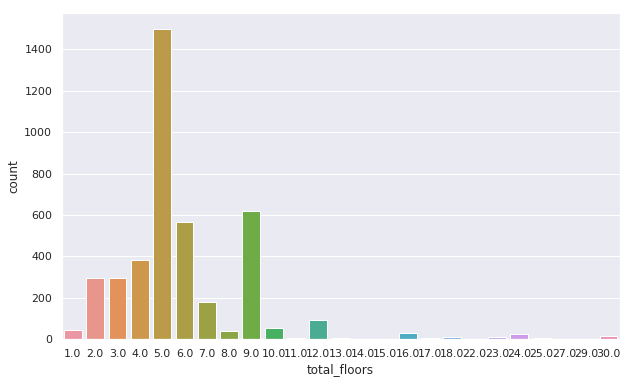

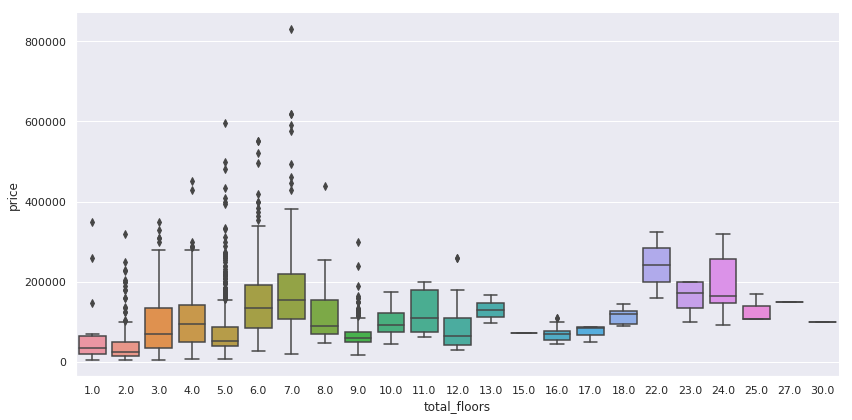

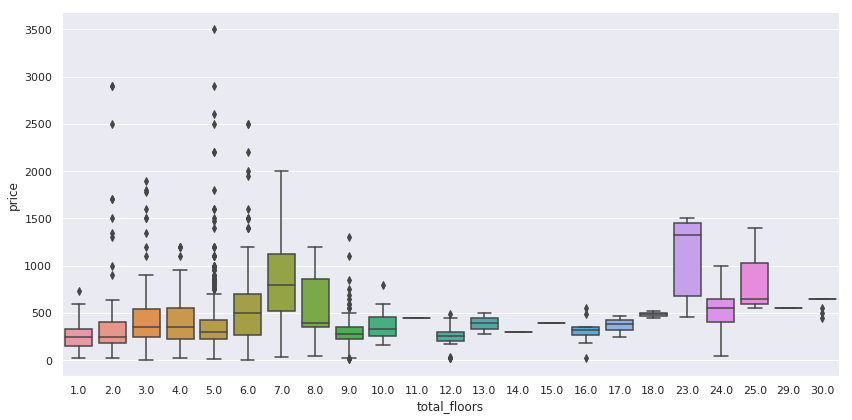

In [73]:
simple_chart(df_all, x = 'total_floors')
factor_chart(df_all[df_all.op_type == 'For sale'], x = 'total_floors', y = 'price', hue = None)
factor_chart(df_all[df_all.op_type == 'For rent'], x = 'total_floors', y = 'price', hue = None)

Same conclusion here as for floors. Seems important, should be included, might have outliers.

**House seria**

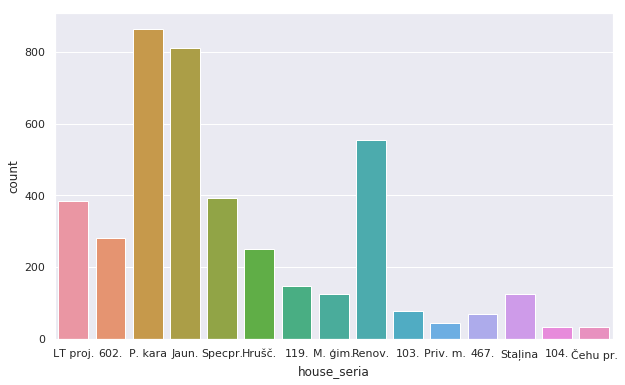

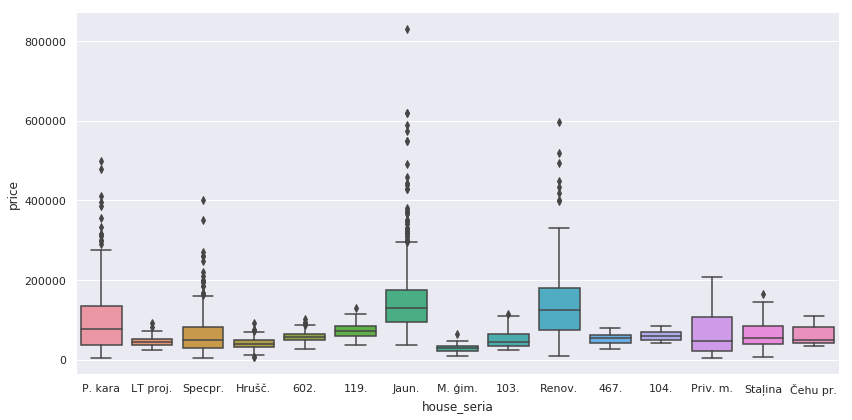

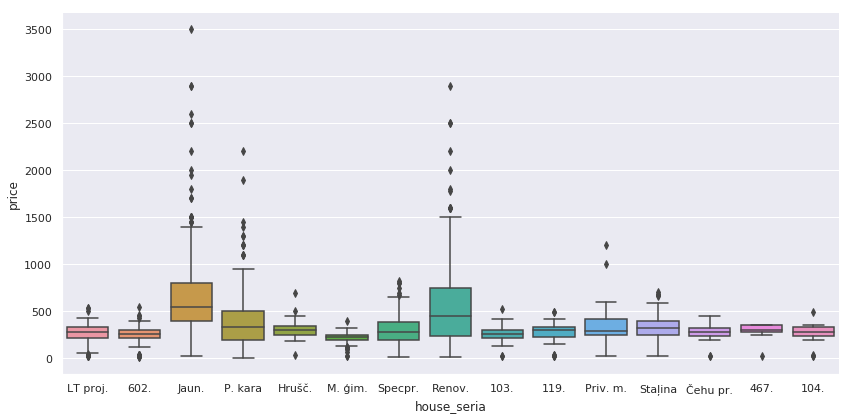

In [74]:
simple_chart(df_all, x = 'house_seria')
factor_chart(df_all[df_all.op_type == 'For sale'], x = 'house_seria', y = 'price', hue = None)
factor_chart(df_all[df_all.op_type == 'For rent'], x = 'house_seria', y = 'price', hue = None)

Some house serias do have varying price levels, so I will dummy them and track their impact in models

Same conclusion goes for **house type**

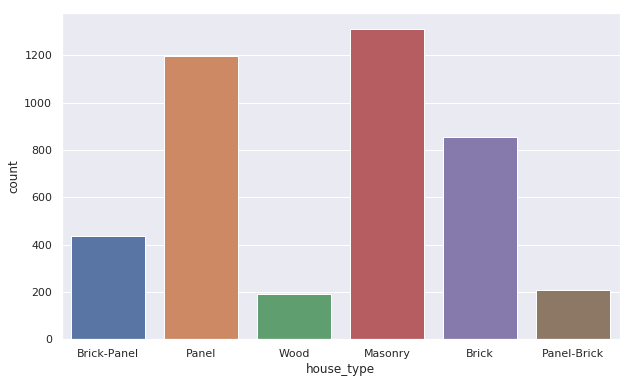

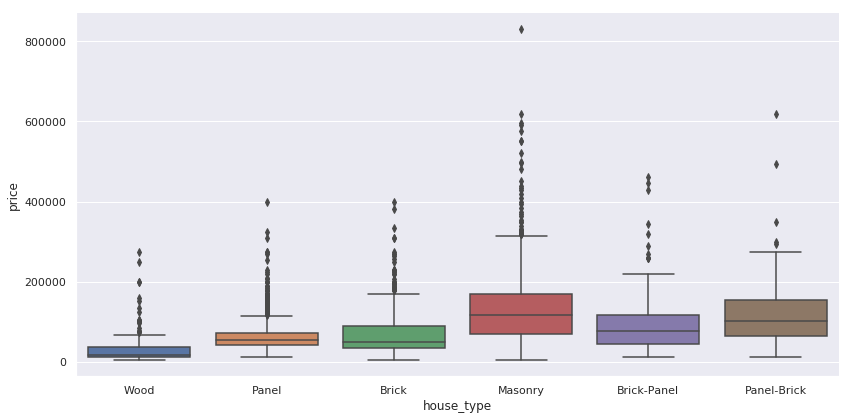

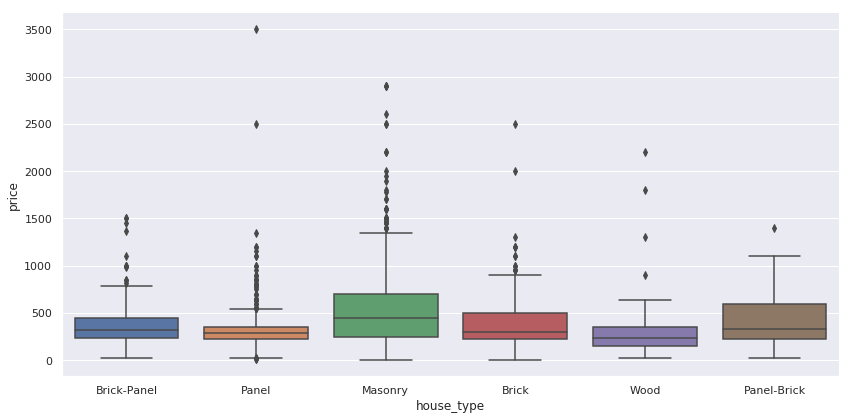

In [75]:
simple_chart(df_all, x = 'house_type')
factor_chart(df_all[df_all.op_type == 'For sale'], x = 'house_type', y = 'price', hue = None)
factor_chart(df_all[df_all.op_type == 'For rent'], x = 'house_type', y = 'price', hue = None)

Districts and streets might have their own specific levels of prices.   
 
Some are prestigious and some are poor, and it can impact the price strongly, while area or distance from center will not track it.  
  
Therefore, this categorical information might be very important, so I will dummy them as well. 

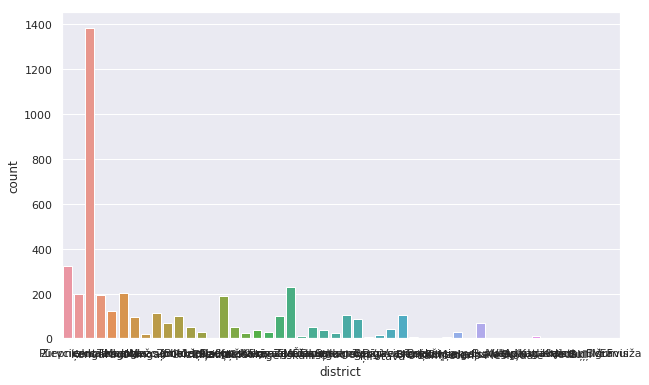

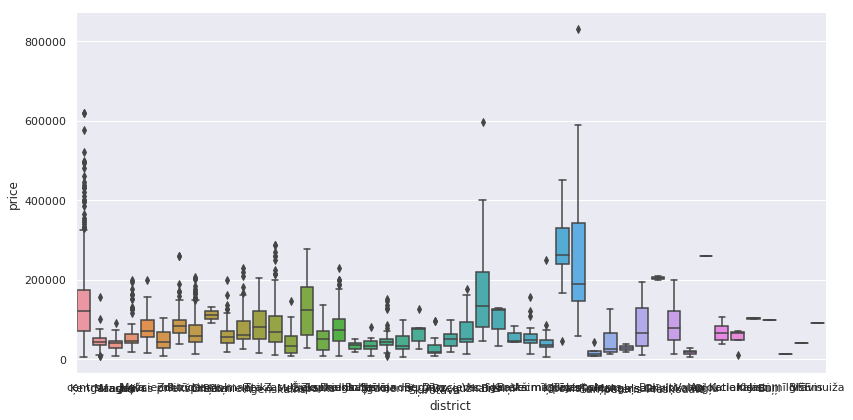

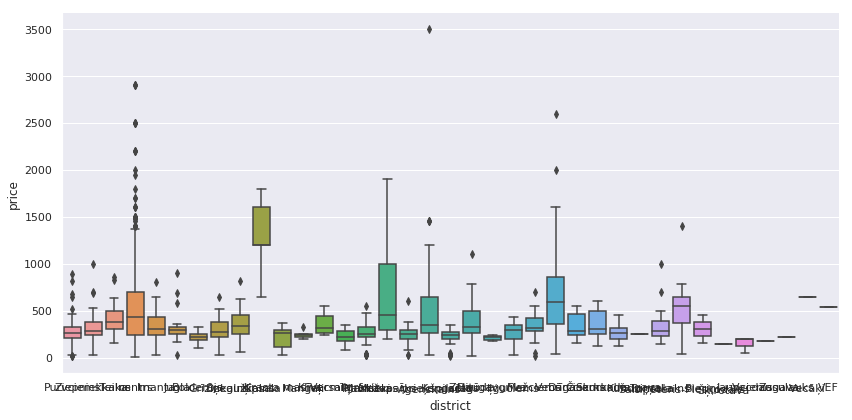

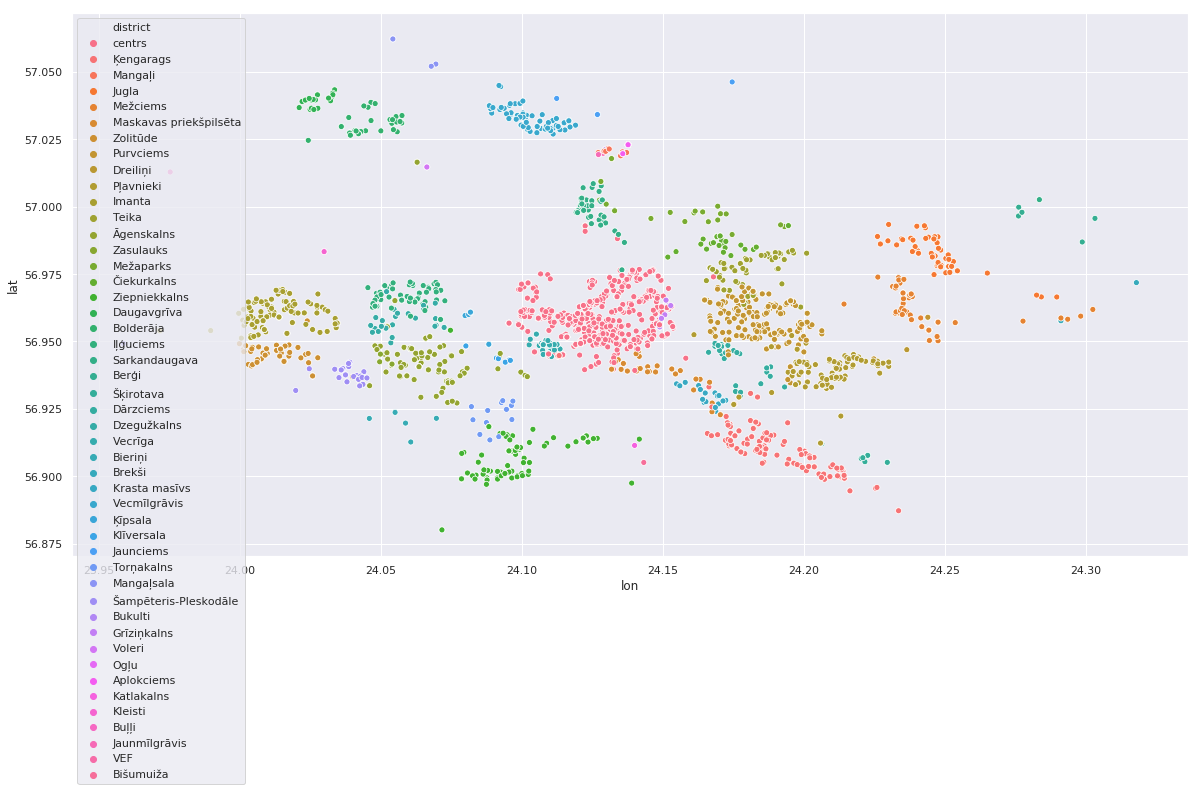

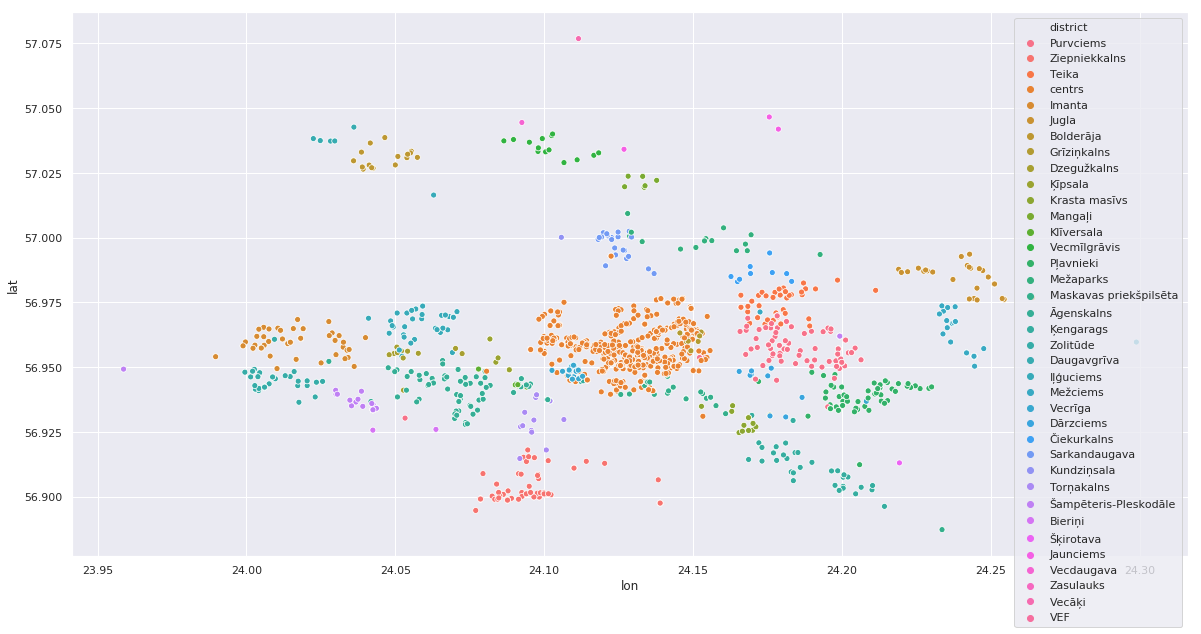

In [76]:
simple_chart(df_all, x = 'district')
factor_chart(df_all[df_all.op_type == 'For sale'], x = 'district', y = 'price', hue = None)
factor_chart(df_all[df_all.op_type == 'For rent'], x = 'district', y = 'price', hue = None)
scatter(df_all[df_all.op_type == 'For sale'], x = 'lon', y = 'lat', hue = 'district')
scatter(df_all[df_all.op_type == 'For rent'], x = 'lon', y = 'lat', hue = 'district')

**lat and lon**

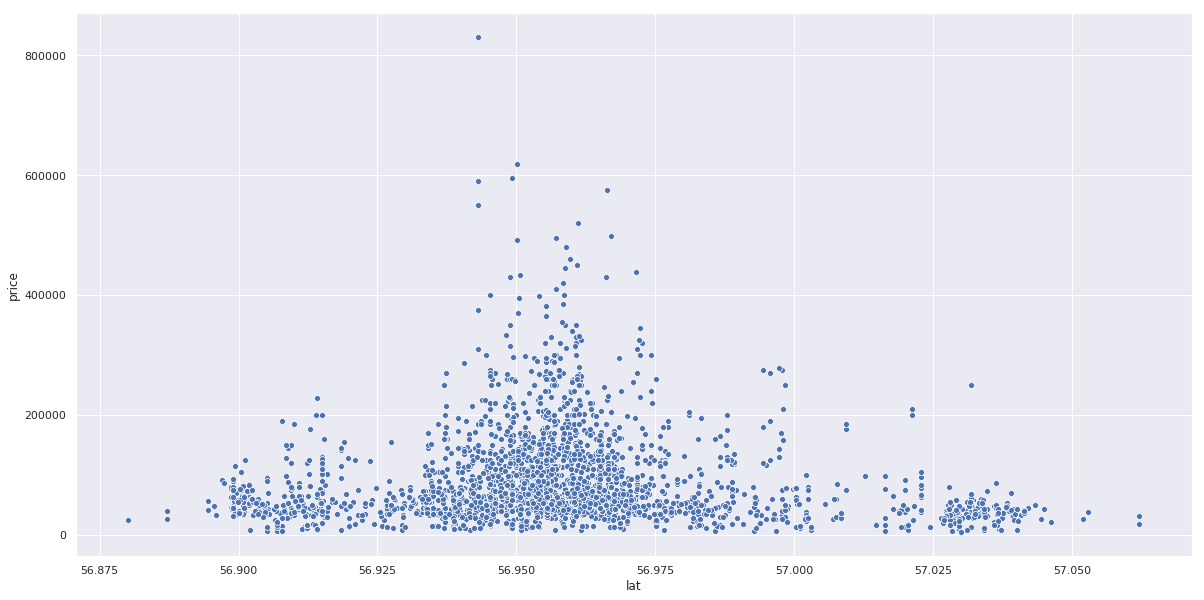

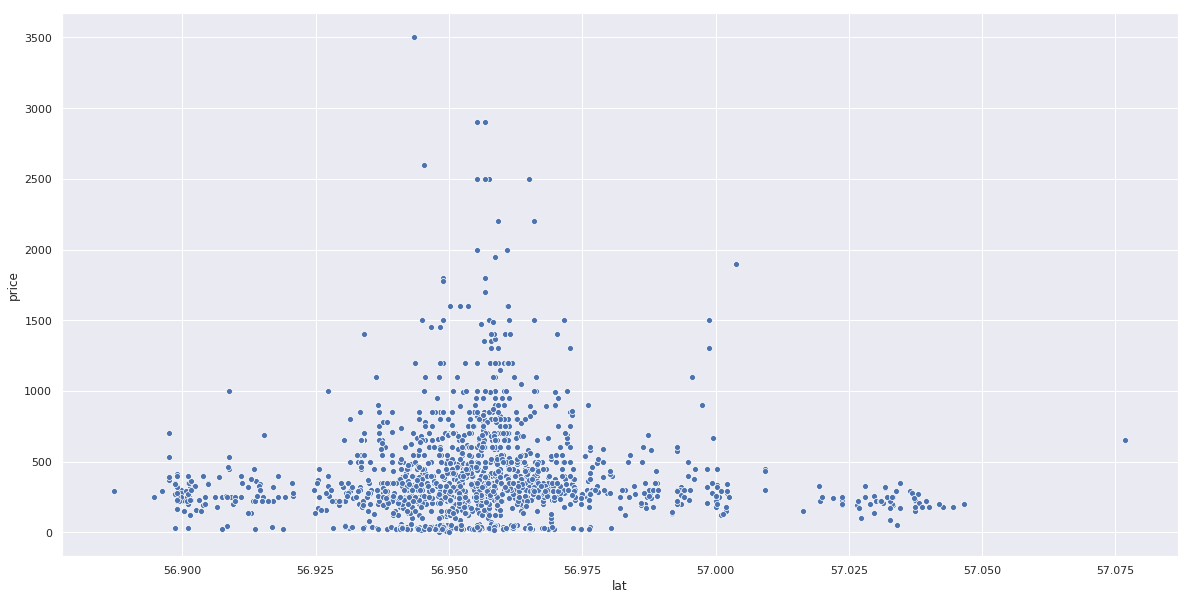

In [77]:
scatter(df_all[df_all.op_type == 'For sale'], x = 'lat', y = 'price', hue = None)
scatter(df_all[df_all.op_type == 'For rent'], x = 'lat', y = 'price', hue = None)

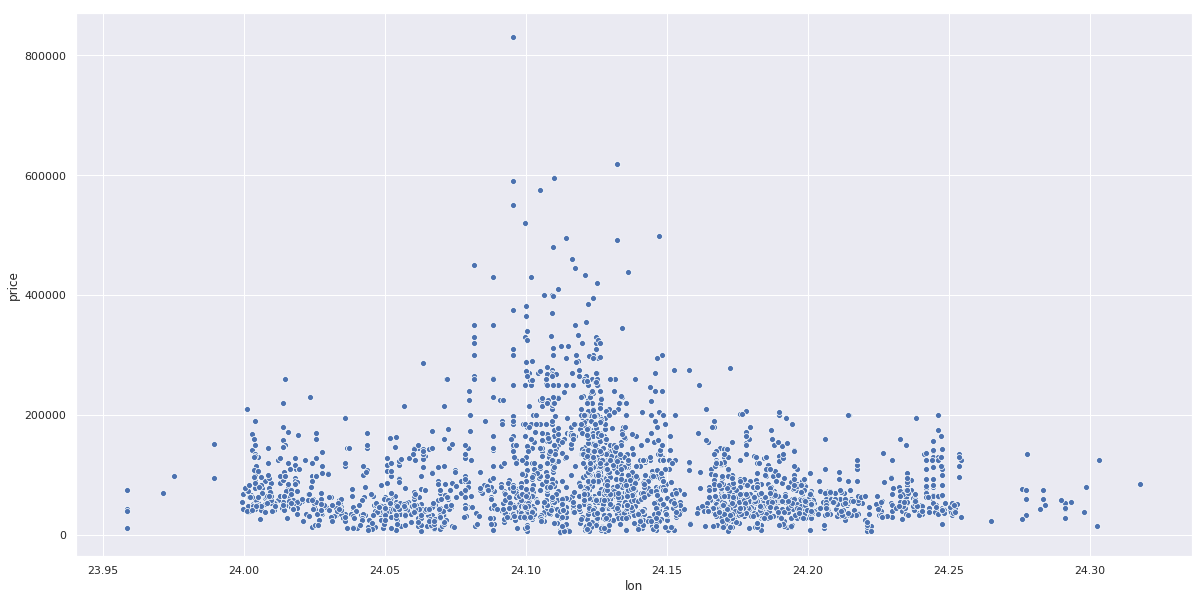

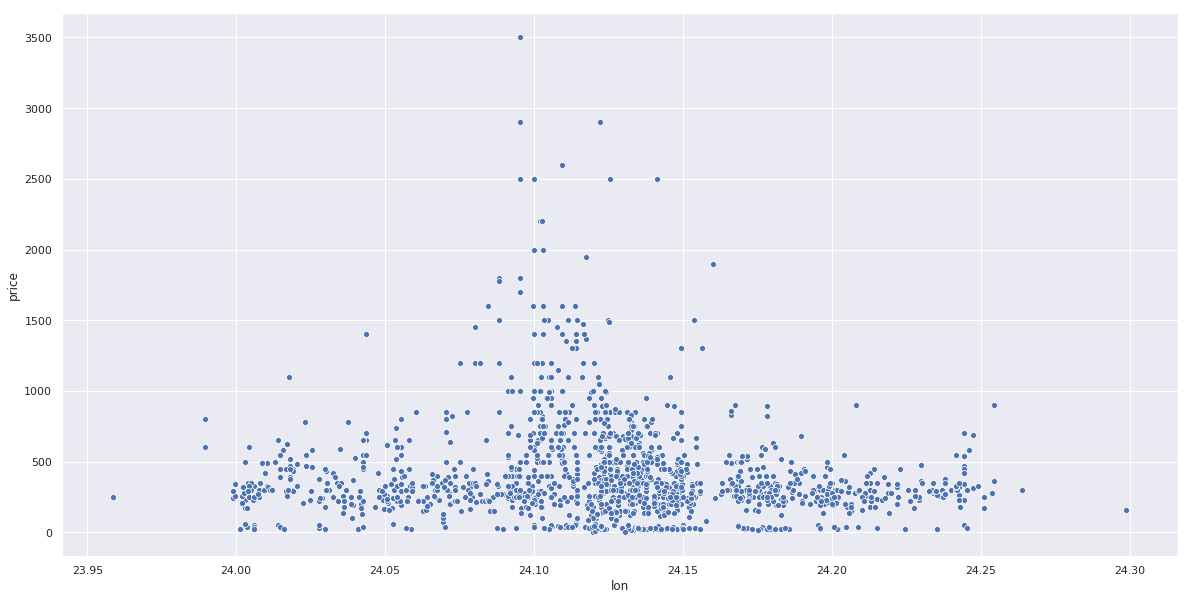

In [78]:
scatter(df_all[df_all.op_type == 'For sale'], x = 'lon', y = 'price', hue = None)
scatter(df_all[df_all.op_type == 'For rent'], x = 'lon', y = 'price', hue = None)

Notice, how price is the higher, the closer a dot is to the center.  
  
Therefore, knowing the coordinates of Riga center, we can calculate each observation's distance from center and use it as a feature.

In [79]:
Riga_Center_Lat = 56.949600
Riga_Center_Lon = 24.105200

In [80]:
import geopy.distance

In [81]:
def center_dist(lat_i, lon_i):
    return geopy.distance.vincenty((Riga_Center_Lat, Riga_Center_Lon), (lat_i, lon_i)).km

In [82]:
df_all['center_dist'] = df_all.apply(lambda x: center_dist(x['lat'], x['lon']), axis = 1)

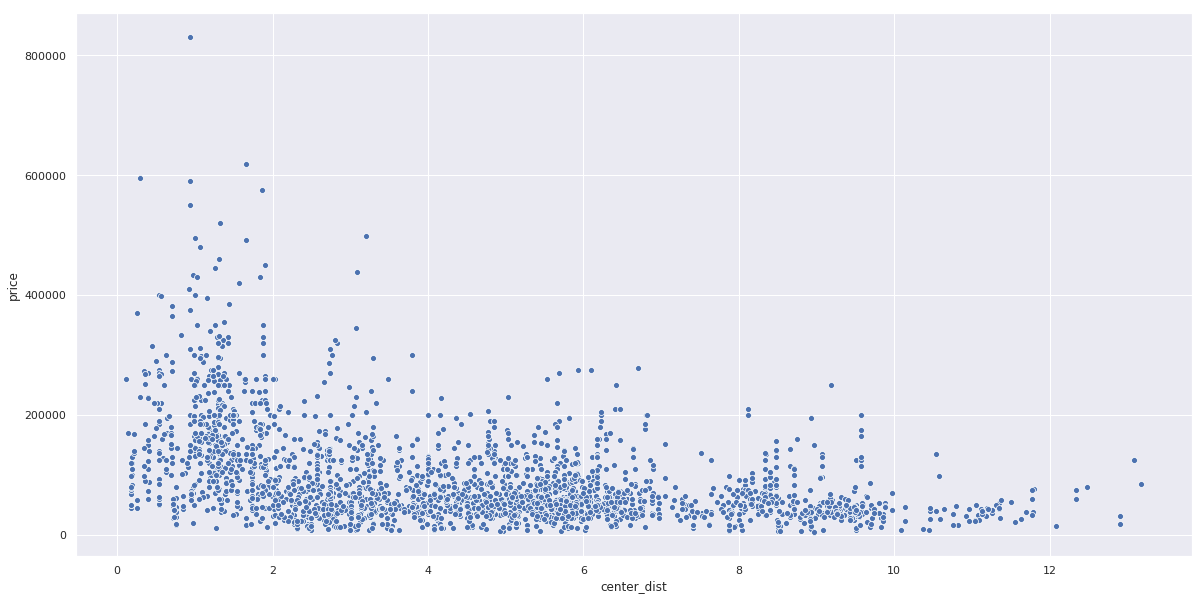

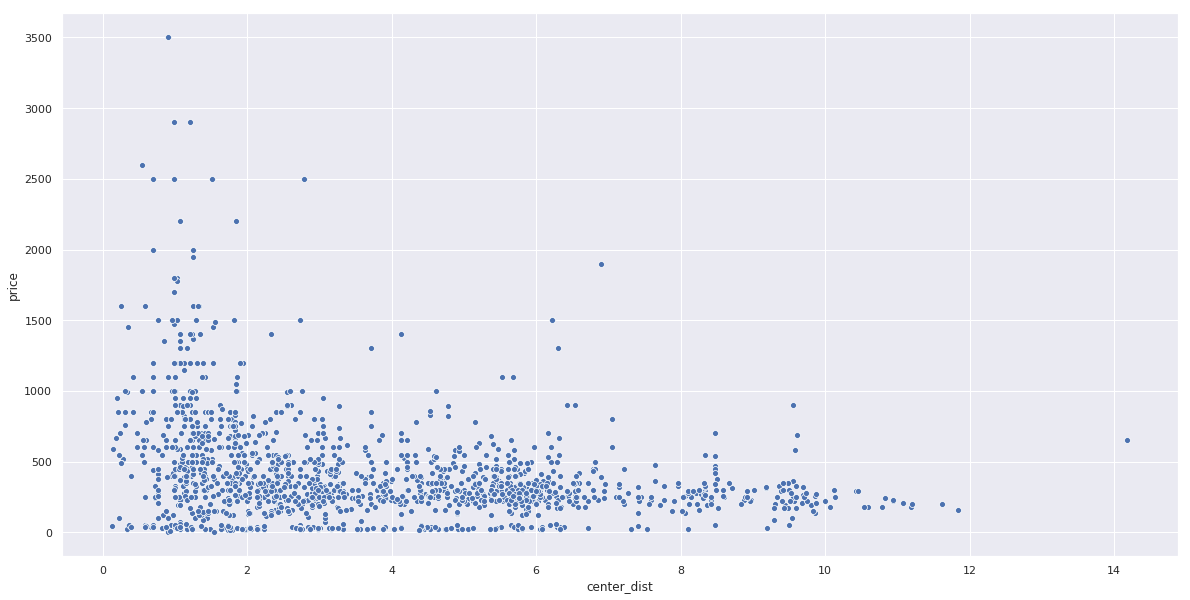

In [83]:
scatter(df_all[df_all.op_type == 'For sale'], x = 'center_dist', y = 'price', hue = None)
scatter(df_all[df_all.op_type == 'For rent'], x = 'center_dist', y = 'price', hue = None)

Expectedly, correlation of center_dist with price is negative and visibly significant, so it will be included in the models

Now, let's introduce some other features, that can improve our predictions additionally

**Area_Room_Ratio** will reflect how big the rooms are in the apartment. The assumption here is that people might prefer  larger rooms

In [84]:
df_all['Area_Room_Ratio'] = df_all.area / df_all.rooms_num

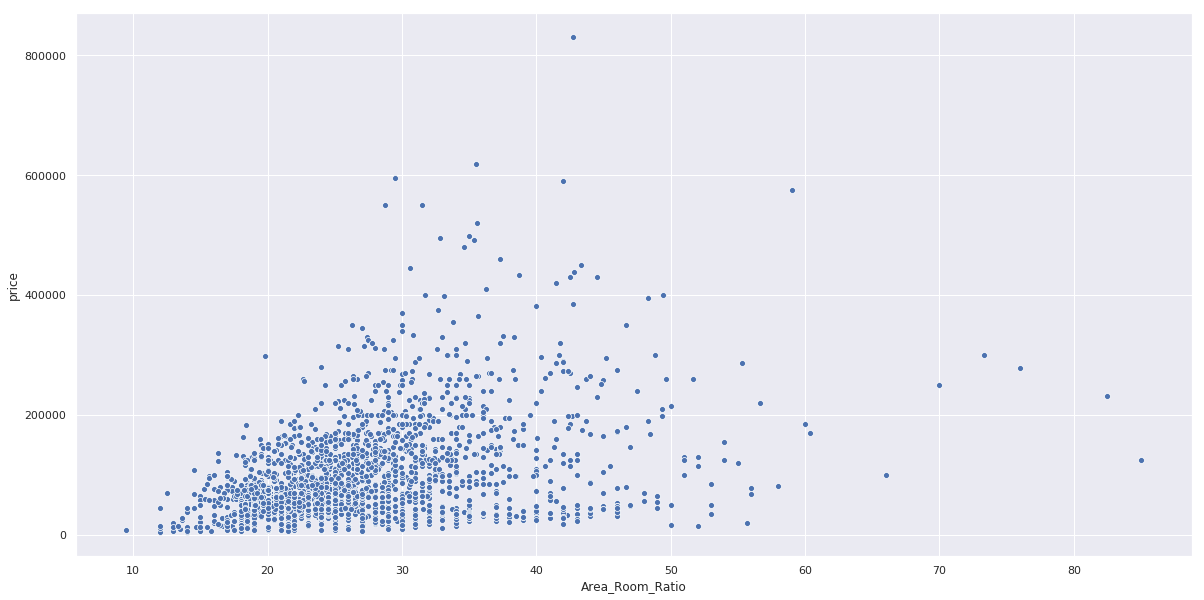

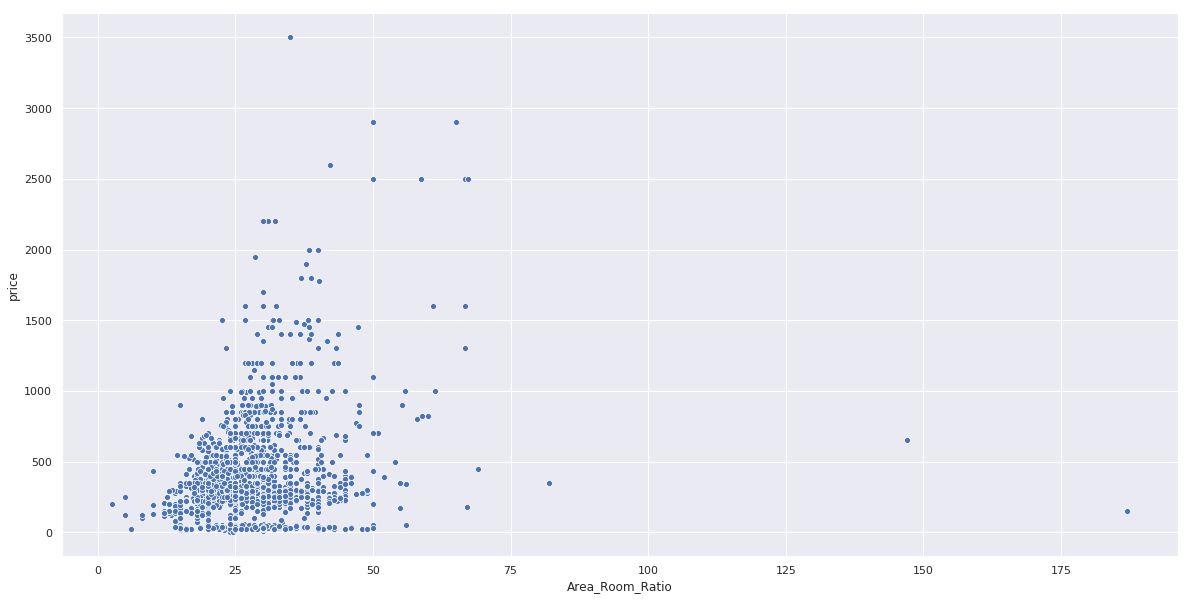

In [85]:
scatter(df_all[df_all.op_type == 'For sale'], x = 'Area_Room_Ratio', y = 'price', hue = None)
scatter(df_all[df_all.op_type == 'For rent'], x = 'Area_Room_Ratio', y = 'price', hue = None)

Seems like my assumption was sort of correct and this feature will be worth to use. Though, some outliers and strong heteroskedasticity remain a problem

**Floor_Ratio**  
The second assumption is that people prefer comparatively higher flats in a house, so their prices are higher for all buildings

In [86]:
df_all['Floor_Ratio'] = df_all.floor / df_all.total_floors 

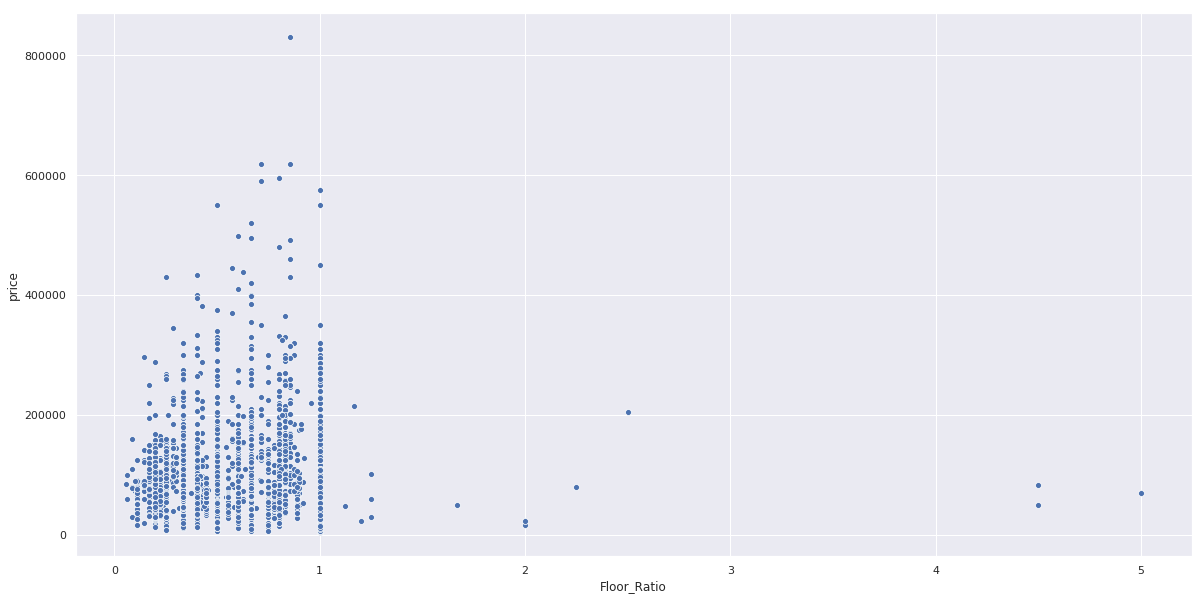

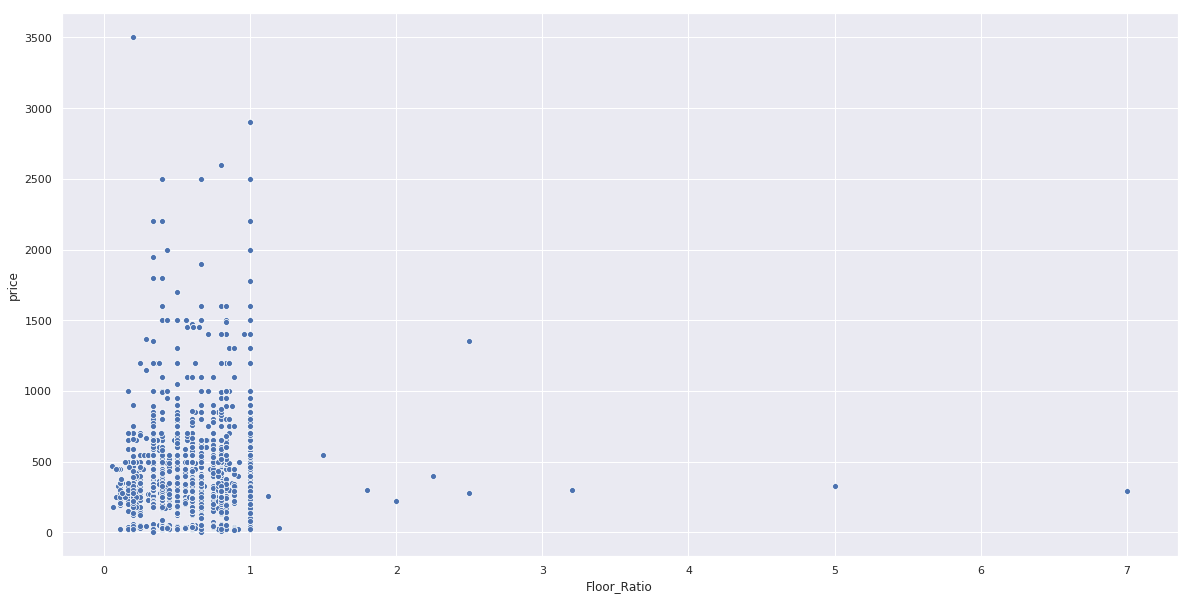

In [87]:
scatter(df_all[df_all.op_type == 'For sale'], x = 'Floor_Ratio', y = 'price', hue = None)
scatter(df_all[df_all.op_type == 'For rent'], x = 'Floor_Ratio', y = 'price', hue = None)

And here we have an unexpected data mistake!  
  
Obviously, Floor_Ratio cannot be higher than 1, but we have such values

In [88]:
df_all[df_all['Floor_Ratio'] > 1]

,op_type,district,street,rooms,area,floor,total_floors,house_seria,house_type,condition,...,lat,lon,st_n,Street_New,Street_Full,rooms_num,All_Amen,center_dist,Area_Room_Ratio,Floor_Ratio
44,For rent,centrs,Asara 15,1,38.0,5.0,2.0,Specpr.,Brick,All amenities,...,56.956367,24.155690,Asara,Asara 15,"Asara iela 15, centrs, Rīga",1,1,3.163325,38.000000,2.500000
110,For rent,Pļavnieki,Ilūkstes 55,1,24.0,2.0,1.0,Priv. m.,Masonry,All amenities,...,56.940384,24.194601,Ilūkstes,Ilūkstes 55,"Ilūkstes iela 55, Pļavnieki, Rīga",1,1,5.537019,24.000000,2.000000
262,For rent,Zolitūde,Gramzdas 19,2,60.0,9.0,5.0,119.,Panel,All amenities,...,56.943513,24.007624,Gramzdas,Gramzdas 19,"Gramzdas iela 19, Zolitūde, Rīga",2,1,5.976937,30.000000,1.800000
353,For sale,Maskavas priekšpilsēta,Daugavpils 76,1,25.0,6.0,5.0,P. kara,Brick,All amenities,...,56.946431,24.141396,Daugavpils,Daugavpils 76,"Daugavpils iela 76, Maskavas priekšpilsēta, Rīga",1,1,2.230880,25.000000,1.200000
515,For sale,Vecmīlgrāvis,Meldru 6,2,43.0,5.0,4.0,Hrušč.,Brick,All amenities,...,57.028462,24.102091,Meldru,Meldru 6,"Meldru iela 6, Vecmīlgrāvis, Rīga",2,1,8.784086,21.500000,1.250000
533,For rent,Zolitūde,Zolitūdes 47,1,45.0,9.0,8.0,119.,Panel,All amenities,...,56.948018,23.999478,Zolitūdes,Zolitūdes 47,"Zolitūdes iela 47, Zolitūde, Rīga",1,1,6.436171,45.000000,1.125000
570,For sale,Dārzciems,Nīcgales 46,2,51.0,9.0,2.0,602.,Panel,All amenities,...,56.945342,24.170947,Nīcgales,Nīcgales 46,"Nīcgales iela 46, Dārzciems, Rīga",2,1,4.029211,25.500000,4.500000
931,For rent,centrs,Jeruzalemes 10,3,125.0,5.0,2.0,Jaun.,Panel,All amenities,...,56.957815,24.114208,Jeruzalemes,Jeruzalemes 10,"Jeruzalemes iela 10, centrs, Rīga",3,1,1.066437,41.666667,2.500000
1135,For rent,centrs,Ģertrūdes 91,1,22.0,6.0,5.0,P. kara,Brick,All amenities,...,56.950357,24.135761,Ģertrūdes,Ģertrūdes 91,"Ģertrūdes iela 91, centrs, Rīga",1,1,1.861639,22.000000,1.200000
1312,For sale,centrs,Eksporta 18,2,38.0,5.0,3.0,Hrušč.,Brick,All amenities,...,56.956763,24.095453,Eksporta,Eksporta 18,"Eksporta iela 18, centrs, Rīga",2,1,0.993991,19.000000,1.666667


It seems like floor and total_floors values are switched for these observations.  
  
Let's switch 'em back then.

In [89]:
df_all.loc[(df_all['Floor_Ratio'] > 1), 'floor'] = df_all['floor'] / df_all['Floor_Ratio']
df_all.loc[(df_all['Floor_Ratio'] > 1), 'total_floors'] = df_all['Floor_Ratio'] * df_all['total_floors']

In [90]:
df_all.loc[(df_all['Floor_Ratio'] > 1), 'Floor_Ratio'] = df_all['floor'] / df_all['total_floors']

In [91]:
df_all[df_all['Floor_Ratio'] > 1]

,op_type,district,street,rooms,area,floor,total_floors,house_seria,house_type,condition,...,lat,lon,st_n,Street_New,Street_Full,rooms_num,All_Amen,center_dist,Area_Room_Ratio,Floor_Ratio


Now we're good!

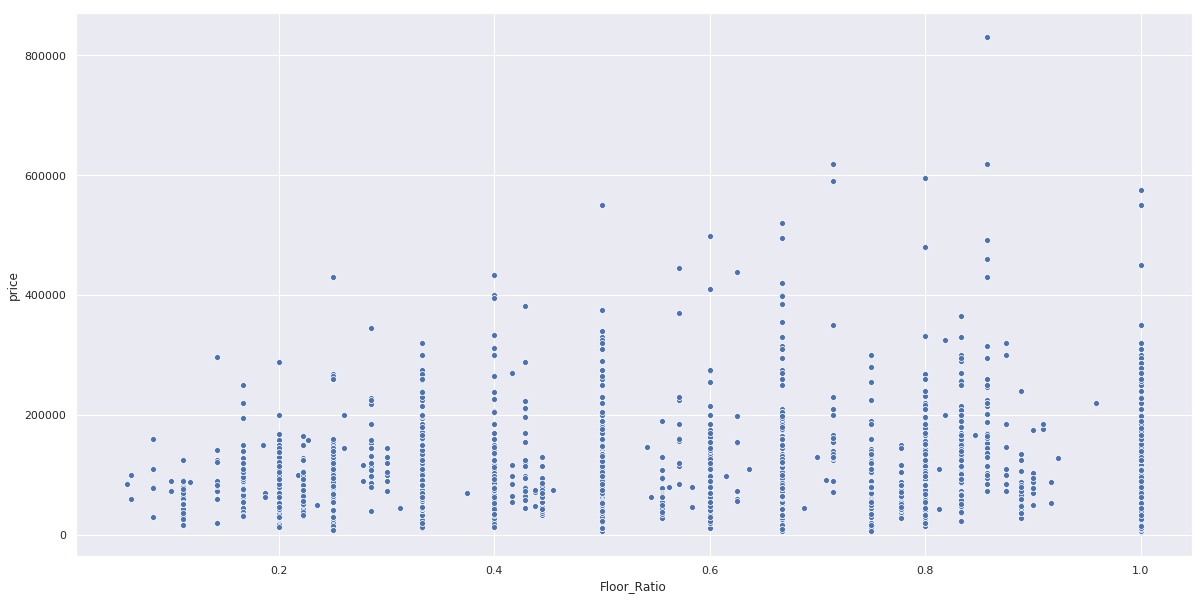

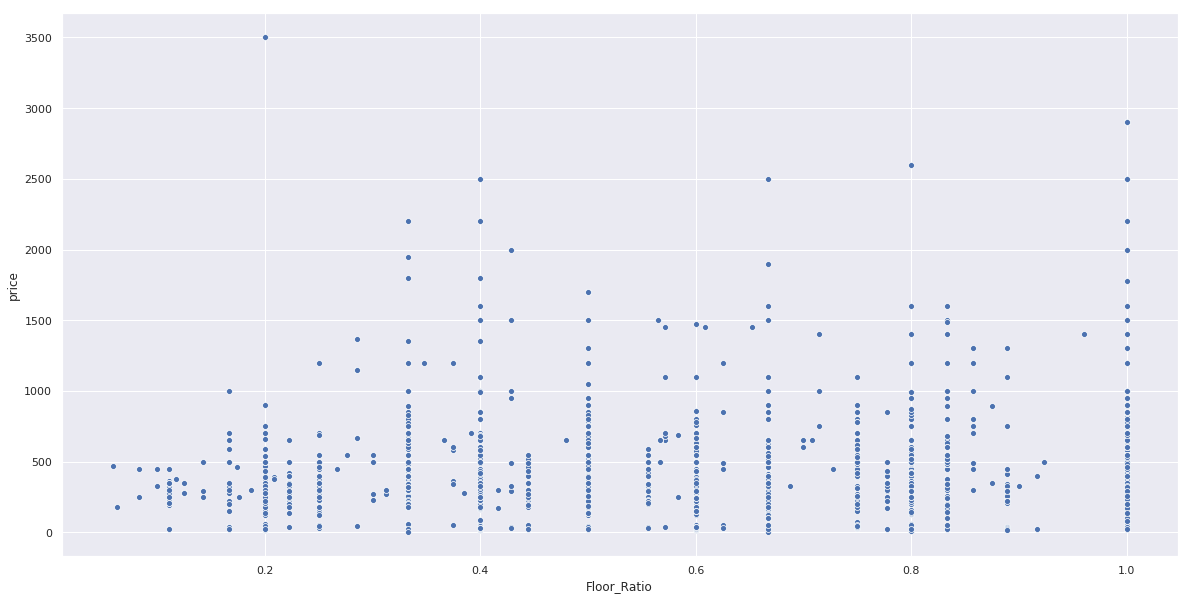

In [92]:
scatter(df_all[df_all.op_type == 'For sale'], x = 'Floor_Ratio', y = 'price', hue = None)
scatter(df_all[df_all.op_type == 'For rent'], x = 'Floor_Ratio', y = 'price', hue = None)

Some positive correlation is visible, so it worths to try this feature in the models

OK, we're almost done with cleaning! What's left is only...

### Dropping outliers

First, it is time to separate our dataset on 2 independent sets and work with them separately now

In [93]:
df_sale = df_all[df_all.op_type == 'For sale'].reset_index(drop = True).copy()
df_rent = df_all[df_all.op_type == 'For rent'].reset_index(drop = True).copy()

Now we go for outliers detection  
  
I've made it basing on observing scatterplots and removing dots that highly deviate.  
 
I decided to not to use quantile outlier detection here because since the values are highly disperced and our datasets are not really big, a big share of information would've been lost and models would've not been describing our data really.  
 
But if this dataset will be expanded later on, I would definitely use boxcox transformation to remove outliers and to build more robust model 

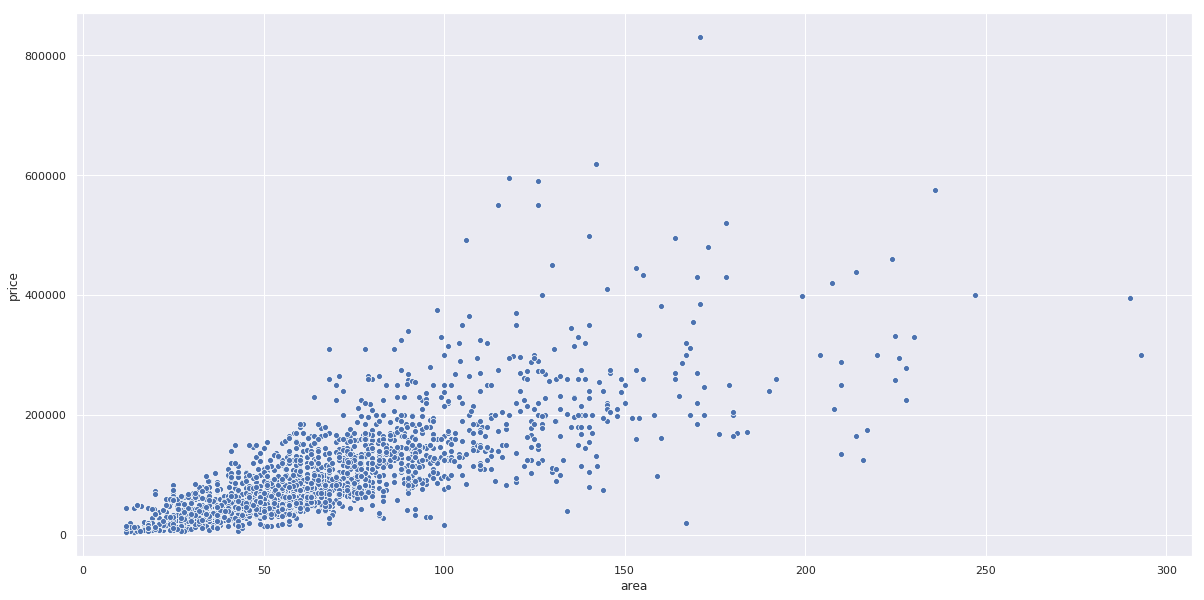

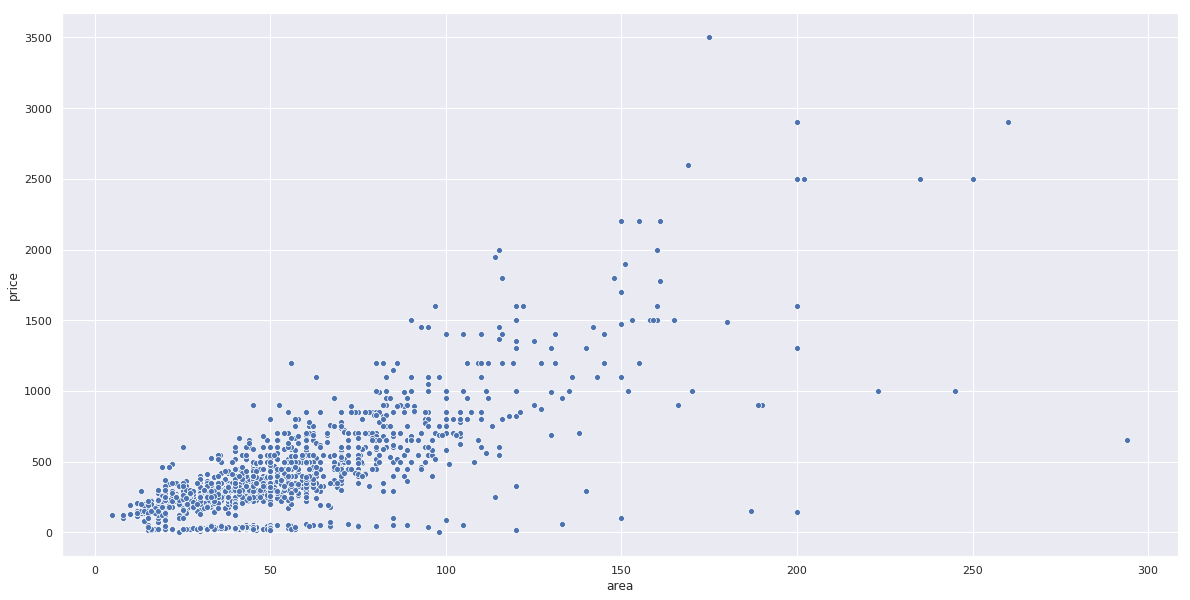

In [94]:
scatter(df_sale, x = 'area', y = 'price', hue = None)
scatter(df_rent, x = 'area', y = 'price', hue = None)

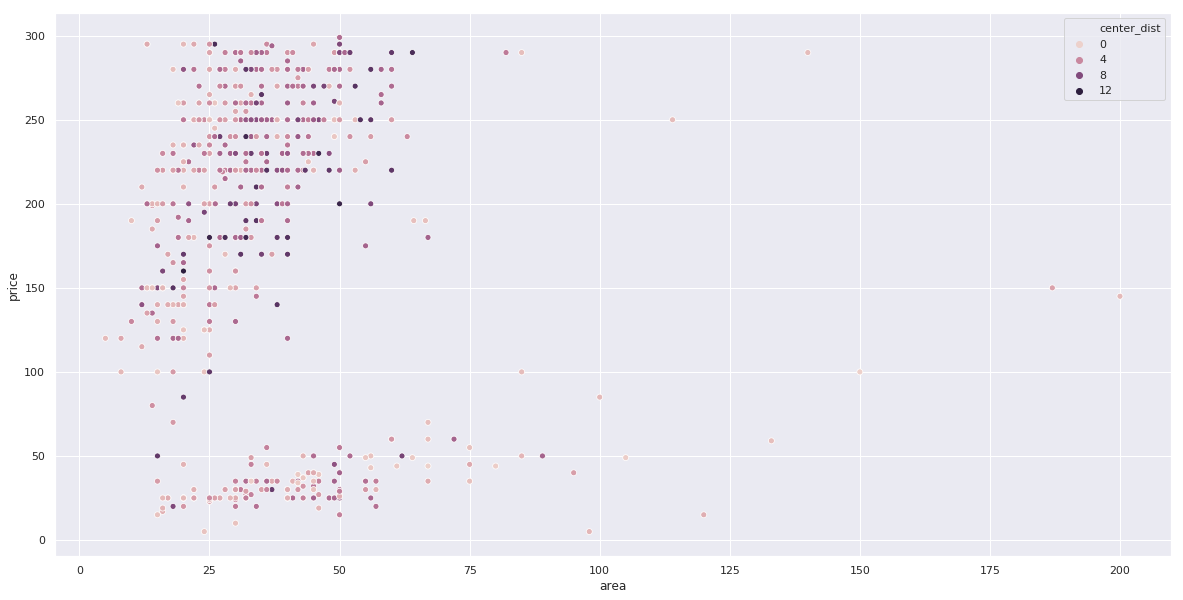

In [95]:
scatter(df_rent[df_rent.price < 300], x = 'area', y = 'price', hue = 'center_dist')

Notice, that in rent dataset there is a relatively big chunk of dots below price = 100, that have their own mood on price.
  
However, playing with 'hue' parameter for the chart I could not find the explaination for this group's deviant behavior. 
 
Therefore, since available features do not explain this, I specify these dots as outliers so they do not harm our model.  
 
If you find the explaination for this, please, let me know.

After some boring iterations of charts I've ended up with these datasets.  
 
Unusually expensive or cheap flats' prices definitely have some other explaination of their deviant prices (such as interior for ex.) so they were removed together with other highly deviated dots

In [96]:
df_sale_clean = df_sale[(df_sale.price < 300000) & (df_sale.area <160)  
                  & (~((df_sale.price < 50000) &(df_sale.area > 80))) 
                 & (~((df_sale.price < 100000)&(df_sale.area > 130)))
                  & (df_sale.Area_Room_Ratio<80)
                 ].copy()

In [97]:
df_rent_clean = df_rent[(df_rent.price < 1390) & (df_rent.area <125) & (df_rent.price > 60) 
                  & (~((df_rent.price < 110) &(df_rent.area > 40))) 
                 & (~((df_rent.price < 400)&(df_rent.area > 100)))
                  & (~((df_rent.price > 1000)&(df_rent.area < 70)))
                  &(df_rent.Area_Room_Ratio < 65)
                 ].copy()

Now charts look more neat and outliers impact is higly reduced.

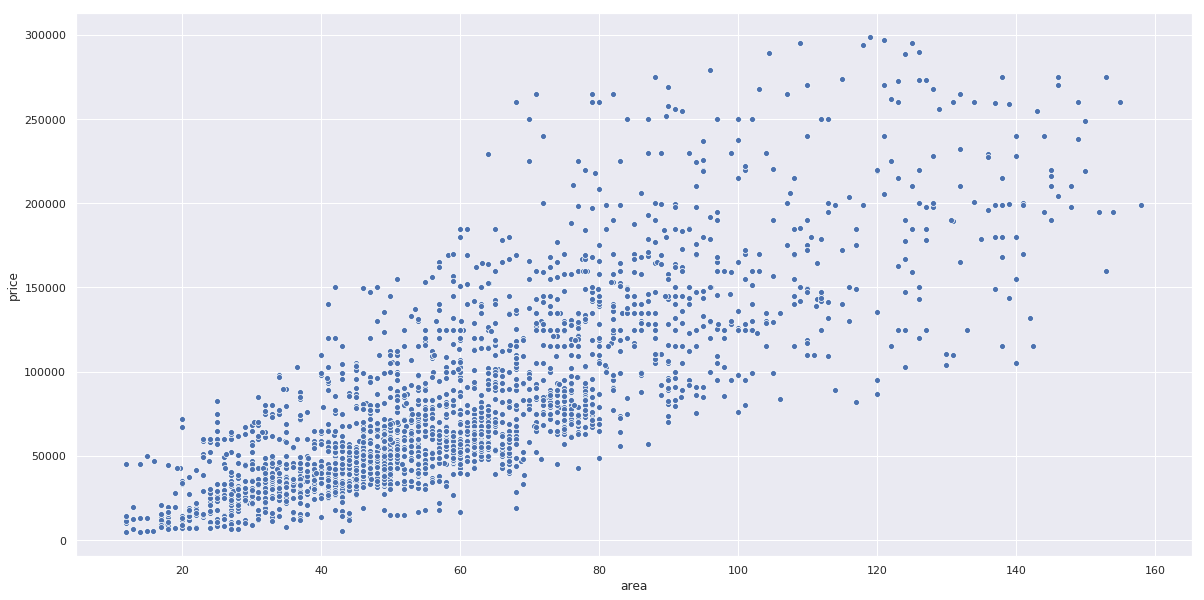

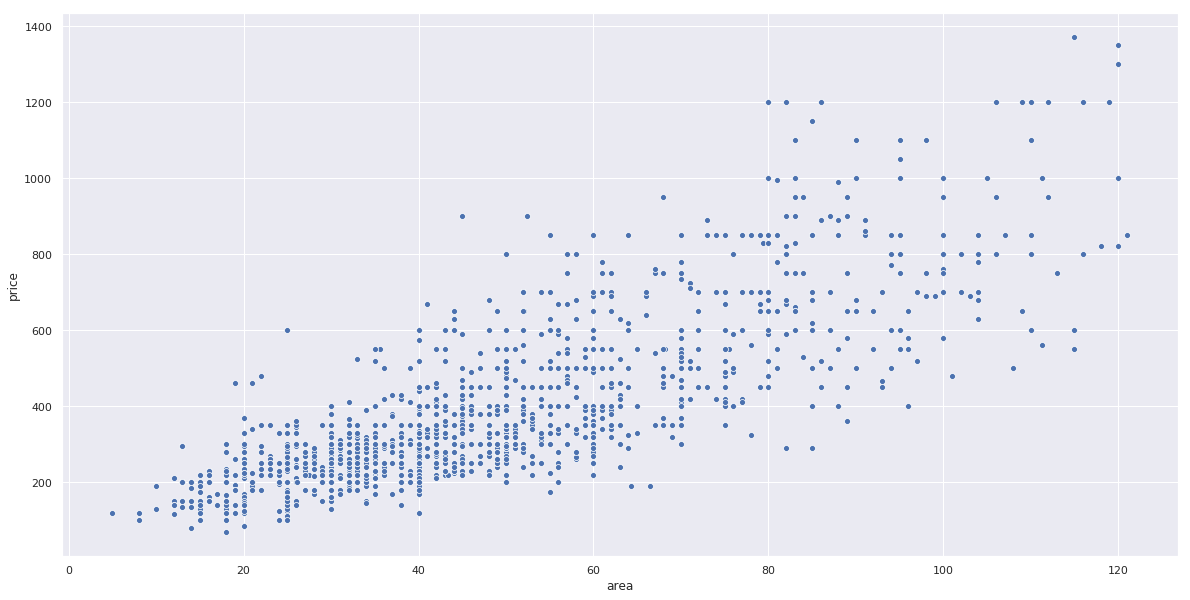

In [98]:
scatter(df_sale_clean, x = 'area', y = 'price', hue = None)
scatter(df_rent_clean, x = 'area', y = 'price', hue = None)

Drop useless columns

In [99]:
df_sale_clean.columns

Index(['op_type', 'district', 'street', 'rooms', 'area', 'floor',
       'total_floors', 'house_seria', 'house_type', 'condition', 'price',
       'lat', 'lon', 'st_n', 'Street_New', 'Street_Full', 'rooms_num',
       'All_Amen', 'center_dist', 'Area_Room_Ratio', 'Floor_Ratio'],
      dtype='object')

In [100]:
df_sale_clean = df_sale_clean.drop(['op_type', 'street', 'rooms', 'condition', 'Street_New', 'Street_Full'], axis = 1)
df_rent_clean = df_rent_clean.drop(['op_type', 'street', 'rooms', 'condition', 'Street_New', 'Street_Full'], axis = 1)

Splitting on test and train

In [101]:
def get_splits(df):
    X_train, X_test, y_train, y_test = train_test_split(df.drop(['price'], axis = 1), 
                                                          df['price'], train_size=0.8, test_size=0.2, 
                                                          random_state = seed)
    return X_train, X_test, y_train, y_test

Get dummies for categorical features

In [102]:
OH_sale_clean = pd.get_dummies(df_sale_clean, drop_first = True)
OH_rent_clean = pd.get_dummies(df_rent_clean, drop_first = True)

In [103]:
OH_sale_train, OH_sale_test, OH_y_sale_train, OH_y_sale_test = get_splits(OH_sale_clean)
OH_rent_train, OH_rent_test, OH_y_rent_train, OH_y_rent_test = get_splits(OH_rent_clean)

Drop columns, that are relevant only for train sets

In [104]:
cols_to_drop_sale = OH_sale_train.columns[(OH_sale_train == 0).all()]
OH_sale_train = OH_sale_train.drop(cols_to_drop_sale, axis = 1)
OH_sale_test = OH_sale_test.drop(cols_to_drop_sale, axis = 1)

In [105]:
cols_to_drop_rent = OH_rent_train.columns[(OH_rent_train == 0).all()]
OH_rent_train = OH_rent_train.drop(cols_to_drop_rent, axis = 1)
OH_rent_test = OH_rent_test.drop(cols_to_drop_rent, axis = 1)

And finally...

### Modelling

First, let's choose the most appropriate models for tuning

In [106]:
models = [RandomForestRegressor(random_state = seed), 
          Ridge(random_state = seed), 
          RidgeCV(), 
          Lasso(random_state = seed), 
          LassoCV(random_state = seed), 
          ElasticNet(random_state = seed),
          HuberRegressor(), 
          KernelRidge(), 
          GradientBoostingRegressor(random_state = seed), 
          ExtraTreesRegressor(random_state = seed), 
          XGBRegressor(random_state = seed)]

In [107]:
models_names = [str(i).split('(')[0] for i in models]

In [108]:
def models_summary(train, test, y_train, y_test):
    models_MAE = []
    models_RMSE = []
    models_RMSLE = []
    for model in models:
        model.fit(train, y_train)
        preds = model.predict(test)
        models_MAE.append(mean_absolute_error(y_test, preds))
        models_RMSE.append(np.sqrt(mean_squared_error(y_test, preds)))
        models_RMSLE.append(np.sqrt(mean_squared_log_error(y_test, abs(preds))))
    return pd.DataFrame(list(zip(models_names, models_MAE, models_RMSE, models_RMSLE)),
              columns=['models','MAE', 'RMSE', 'RMSLE']).sort_values(by = 'MAE').set_index('models')

For sale:

In [109]:
models_sale_res = models_summary(OH_sale_train, OH_sale_test, OH_y_sale_train, OH_y_sale_test)
models_sale_res

[14:49:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,MAE,RMSE,RMSLE
models,,,
ExtraTreesRegressor,11501.255547,19037.991021,0.231569
RandomForestRegressor,12810.049148,19925.830148,0.248770
XGBRegressor,13660.296570,20265.136602,0.258091
GradientBoostingRegressor,13927.377155,20774.046461,0.257675
Ridge,15097.325278,21382.201599,0.413321
RidgeCV,15097.325280,21382.201599,0.413321
KernelRidge,15097.764119,21382.294578,0.412036
HuberRegressor,15207.674756,22384.782206,0.388222
Lasso,15582.509206,22597.069879,0.403544


For rent:

In [110]:
models_rent_res = models_summary(OH_rent_train, OH_rent_test, OH_y_rent_train, OH_y_rent_test)
models_rent_res

[14:49:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,MAE,RMSE,RMSLE
models,,,
ExtraTreesRegressor,65.253605,96.645751,0.198536
GradientBoostingRegressor,68.141798,101.185485,0.206296
RandomForestRegressor,69.073902,107.020143,0.209917
XGBRegressor,70.835896,104.461929,0.209344
KernelRidge,74.465914,103.166980,0.238381
RidgeCV,74.483150,103.185105,0.238425
Ridge,74.483150,103.185105,0.238425
HuberRegressor,74.890316,107.356898,0.227953
Lasso,75.657697,107.191224,0.233293


Seems like **ExtraTrees** has the lowest MAE, RMSE and RMSLE for both sets and it is the best fit for our disperced data.  
 
Of course, this results do not take tuning into account and famous XGB or GBS potentially can outbeat ExtraTrees.  
 
However, I've tuned them by myself and ExtraTrees still was the best for my datasets.  
 
Therefore, I will show results only for this model, but if you manage to overcome my scores with XGB - please, let me know!

### Tuning ExtraTrees
For this purpose I will use combined dataset and use GridSearch on 5 kfolds. This will allow to getan average error score for any split wilth the same train/set proportion as we set before (80/20).  
  
Below I already selected my combination of parameters that I consider the best by efficiency and time ratio,but youcan play with your parameters here. 
 
Note, that you can achieve higher scores by setting higher n_estimators, but you'd have to wait longer.

In [111]:
kf = KFold(n_splits=5, random_state=seed)

In [112]:
ET_model = ExtraTreesRegressor(random_state = seed,
                                n_estimators=400, 
                                min_samples_split=2,
                                min_samples_leaf=1, 
                                max_features=200,
                              )

params_grid = {#'n_estimators': range(50,50,201),
               #'max_features': range(50,401,50),
               #'min_samples_split': range(2,5),
               #'min_samples_leaf': range(1,4)
              }  

ET_grid = GridSearchCV(estimator = ET_model, param_grid = params_grid, n_jobs = -1,
                               cv = kf, scoring = 'neg_mean_absolute_error')

In [113]:
ET_grid_sale = ET_grid.fit(OH_sale_clean.drop(['price'], axis = 1), OH_sale_clean.price)
print(ET_grid_sale.best_params_)
print(ET_grid_sale.best_score_)

{}
-12200.672767078697


In [114]:
ET_grid_rent = ET_grid.fit(OH_rent_clean.drop(['price'], axis = 1), OH_rent_clean.price)
print(ET_grid_rent.best_params_)
print(ET_grid_rent.best_score_)

{}
-66.31993350903387


So for the sale dataset we can expect **MAE** around **12200** and for rent **MAE** around **66.32** in average case scenario.  
 
By increasing n_estimatiors, MAE score can be reduced by ~150 and ~4 for sale and rent datasets respectively

Let's calculate our results for our selected train and test sets:

In [115]:
ET_sale = ExtraTreesRegressor(random_state = seed,
                                n_estimators=400, 
                                min_samples_split=2,
                                min_samples_leaf=1, 
                                max_features=200,
                              )
ET_rent = ExtraTreesRegressor(random_state = seed,
                                n_estimators=400, 
                                min_samples_split=2,
                                min_samples_leaf=1, 
                                max_features=200,
                              )

In [116]:
def score(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return mean_absolute_error(y_test, preds)

In [117]:
score(ET_sale, OH_sale_train, OH_sale_test, OH_y_sale_train, OH_y_sale_test)

11473.258999023437

In [118]:
score(ET_rent, OH_rent_train, OH_rent_test, OH_y_rent_train, OH_y_rent_test)

64.62533914728682

Here we ahcieve **MAE 11473** for sale houses and **64.62** for rent and we can see that tuning has helped to slightly improve our score compare the baseline model, where we had MAE 11501 for sale and 65.25 for rent.
 
I think it's not so bad, but can't yet say so (waiting for your kernel here!)

Now I'd like to take a closer look on performance of our models

In [119]:
def results(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    res_tab = pd.DataFrame({'y_test': y_test, 'preds': preds, 'error': (preds - y_test),
             'error_share': abs(y_test - preds)/y_test}).sort_values(by = 'error_share', ascending = False)
    return res_tab

In [120]:
sale_results = results(ET_sale, OH_sale_train, OH_sale_test, OH_y_sale_train, OH_y_sale_test)
rent_results = results(ET_rent, OH_rent_train, OH_rent_test, OH_y_rent_train, OH_y_rent_test)

In [121]:
sale_results[:10]

,y_test,preds,error,error_share
2207,11790.0,34512.3100,22722.3100,1.927253
908,6890.0,19916.9750,13026.9750,1.890708
2241,19000.0,54668.5550,35668.5550,1.877292
1930,6900.0,18632.1375,11732.1375,1.700310
31,6790.0,15990.4750,9200.4750,1.355004
220,18900.0,43227.2825,24327.2825,1.287158
1355,21500.0,47415.3500,25915.3500,1.205365
1475,7300.0,14873.0950,7573.0950,1.037410
902,12800.0,25864.1975,13064.1975,1.020640
782,35000.0,69845.9000,34845.9000,0.995597


In [122]:
rent_results[:10]

,y_test,preds,error,error_share
1296,85.0,170.0000,85.0000,1.000000
1367,80.0,148.5875,68.5875,0.857344
949,200.0,307.7750,107.7750,0.538875
1105,900.0,425.2000,-474.8000,0.527556
1392,250.0,379.1625,129.1625,0.516650
416,600.0,295.1625,-304.8375,0.508062
690,620.0,315.6250,-304.3750,0.490927
1359,100.0,148.4375,48.4375,0.484375
1095,300.0,155.5125,-144.4875,0.481625
276,600.0,887.5500,287.5500,0.479250


To make everything visible, let's plot error and error_share from lowest to highest 

In [123]:
def error_lines(df, y):
    plt.figure(figsize = (10, 6))
    ax = sns.lineplot(x = range(len(df)), y = y, data = df.sort_values(by = [y], ascending = False))

For sale:

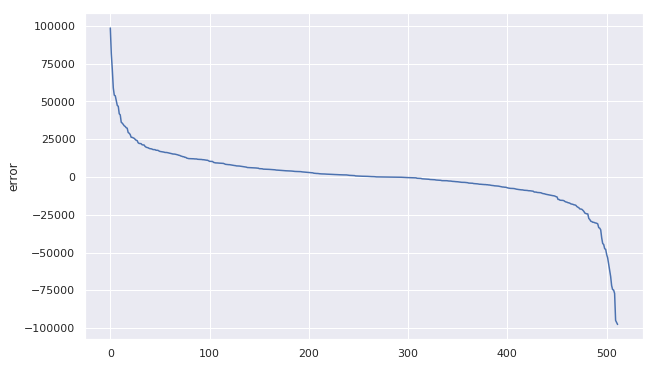

In [124]:
error_lines(sale_results, 'error')

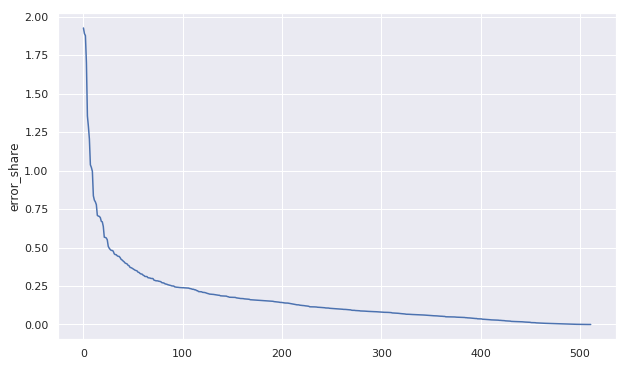

In [125]:
error_lines(sale_results, 'error_share')

Right and left sides of the error graphs are symmetric and the graph is centered around 0.  
 
This allows us to say that our model is not over or underestimating price and most errors explained by outliers.  
 
Other graph shows, that we mistake less by 10% for the half of the set and less than 25% for nearly 80% of the set.  
  
So yeah, not so bad! 
  
I guess...

For rent:

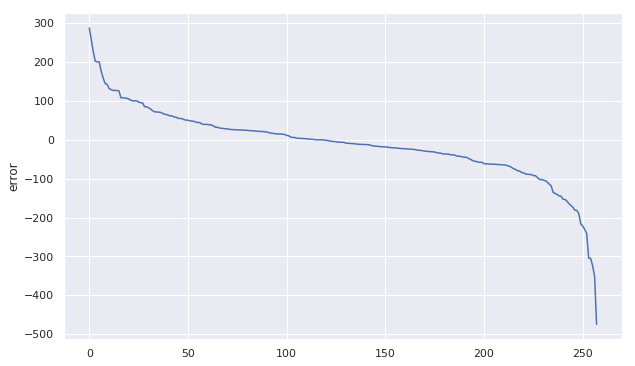

In [126]:
error_lines(rent_results, 'error')

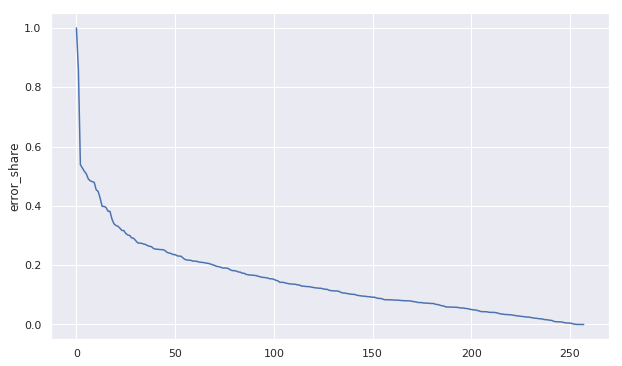

In [127]:
error_lines(rent_results, 'error_share')

Here we see that model for rent type apartments used to underestimate y value, so more careful work with low-price outliers can help to reduce error rate greatly.  
 
Still, model performs quite good, having less than 20% error share for 80% of the observations. 

### CONCLUSION 

Ok, so far I've managed to build a model that is seemingly not bad.  
 
To get better scores I've tried to tune all of the mentioned models, used log1p in order to handle heteroscedasticity problem that our values clearly have, tried different combination of mentioned features etc.  
 
Here I present you the best of mine, but I believe you can do it better!  
 
To give you some ideas:  
 
1) More outliers can be removed with box-cox tool so the model will be more robust to them (but maybe will lose explanatory power)  
 
2) Try other 'fashionable' models like LightGBM and CatBoost. Due to some problems with my python packages I could not install them properly, so maybe they will outperform ExtraTrees here  
 
3) My model clearly has too much features, so I suspect it is Multidimensionally cursed. 
Definitely, most of it comes from huge number of streets dummies. Not using them would drop my model performance, but maybe there is a way to cleverly choose or group some of them.  

4) To tackle heteroskedasticity you can apply log1p to the features like area, Area/Room ratio, Floor/Max floor ration or to the target variable itself. This can mitigate the negative effect of outliers, which are definitely worsening my score a lot.

That's all from me, guys!  
 
Let me know if you found any better solutions or my mistakes and if you have any advice for my model, stats and code overall (I know it's not the state of the art at all, so your criticism is highly welcome) 
 
Peace!